# Hands-On NLP
## Class 4

<span style="color:magenta">Group Names:</span>

* Zhe HUANG
* Lanshi FU
* Pierre QIU

### Outline:

- Simple tokenization

- Words and indices

- Initialization

- Visualization

- Forward, cost, backward, training

- First on a sentence, then on a larger text

Main goal: understand the transformations needed to obtain vector representations

In [4]:
import doctest
import re
from collections import Counter
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from sklearn import preprocessing

In [5]:
tqdm.pandas()

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 4)

print("sklearn's version:", sklearn.__version__)    # 1.2.0
print("pandas's version:", pd.__version__)          # 1.5.2

sklearn's version: 1.2.0
pandas's version: 1.5.2


In [6]:
%config InlineBackend.figure_format="retina"  # For high DPI display

In [7]:
doctest.testmod(optionflags=doctest.ELLIPSIS)

TestResults(failed=0, attempted=0)

In [8]:
DATA = Path("./data/enwiki")

enwiki_fp = DATA / "enwiki-50k_100d-clean.txt"

EPS = np.finfo(float).eps

Optional TODO: 

- You might want to improve on this simple regular expression based tokenize function that only takes consecutive letters as tokens, throws away all the punctuation and puts everything to lower case

In [9]:
# Optional TODO: improve

TOK_RE = re.compile(r"[\w+\-\']+")

SENT = "We get all the word vectors of all the words of all the languages."
# SENT = "Let's do hands-on Natural Language Processing!"
# SENT = "Il m'a bien ennervée, ce gars-là, avec ce copier-coller !"


def tokenize(t):
    """Tokenize a text into a list of tokens.
    >>> tokenize("Il m'a bien ennervée, ce gars-là, avec ce copier-coller !")
    ['Il', "m'a", 'bien', 'ennervée', 'ce', 'gars-là', 'avec', 'ce', 'copier-coller']
    >>> tokenize("Let's do hands-on Natural Language Processing!")
    ["Let's", 'do', 'hands-on', 'Natural', 'Language', 'Processing']
    >>> tokenize(
    ...     "We get all the word vectors of all the words of all the languages."
    ... )
    ['We', 'get', 'all', 'the', 'word', 'vectors', 'of', 'all', 'the', 'words', 'of', 'all', 'the', 'languages']
    """
    
    return TOK_RE.findall(t)



print(tokenize(SENT))

['We', 'get', 'all', 'the', 'word', 'vectors', 'of', 'all', 'the', 'words', 'of', 'all', 'the', 'languages']


In [10]:
Counter(tokenize(SENT)).most_common()

[('all', 3),
 ('the', 3),
 ('of', 2),
 ('We', 1),
 ('get', 1),
 ('word', 1),
 ('vectors', 1),
 ('words', 1),
 ('languages', 1)]

In [11]:
def mapping(tokens):
    """
    🚧 TODO:
    describe types, shape, input, and output size of this function
    
    :param tokens: List[str]
    :return tok2id: Dict[str, int] of number of token's types
    :return id2tok: Dict[int, str] of number of token's types

    end TODO
    """
    tok2id = dict()
    id2tok = dict()

    for i, (token, _) in enumerate(Counter(tokens).most_common()):
        tok2id[token] = i
        id2tok[i] = token

    return tok2id, id2tok

### CBOW

For the calculation of the word2vec we also have the CBOW (continuous bag of words) method as an alternative to Skipgram.
In CBOW, we try to predict the central word from the whole context of the central word.
Our xs, ys training data have fewer inputs, only as many as the text has words, but are richer.
For prediction, we sum the context vectors to predict the center.

In [12]:
def generate_training_data_cbow(tokens, window_size):
    """
    Create the pairs xs, ys for the training:
    xs and ys have the same length (index of the central word,
    index of an observed word of the context of the central word)
    """
    tokens_n = len(tokens)
    tok2id, _ = mapping(tokens)
    xs, ys = [], []

    for i in range(tokens_n):
        # 🚧 TODO : complete the code to fill xs and ys. xs is a list of lists.
        
        index_i = tok2id[tokens[i]]
        
        # xs[i] is index list of the context words(of the central word); ys[i] is index of the central word
        min_index = max(i-window_size, 0)
        max_index = min(i+window_size, tokens_n-1)
        
        xs.append([tok2id[tokens[j]] for j in range(min_index, max_index+1) if j != i])
        ys.append(index_i)
    
        # end TODO

    return xs, ys

### Skipgram

In [13]:
def generate_training_data_skip(tokens, window_size):
    """
    create the pairs xs, ys for the training:
    xs and ys have the same length (index of the central word,
    index of an observed word of the context of the central word)
    
    >>> tokens = ["we", "get", "all", "the", "word", "vectors", "of", "all", 
    ...           "the", "words", "of", "all", "the", "languages"]
    >>> xs, ys = generate_training_data_skip(tokens, window_size=3)
    >>> len(xs[0]), len(ys[0])
    (72, 72)
    >>> xs[0][:24]
    [3, 3, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5]
    >>> ys[0][:24]
    [4, 0, 1, 3, 0, 1, 5, 3, 4, 1, 5, 6, 3, 4, 0, 5, 6, 2, 4, 0, 1, 6, 2, 0]
    """
    tokens_n = len(tokens)
    tok2id, _ = mapping(tokens)
    xs, ys = [], []

    for i in range(tokens_n):
        # 🚧 TODO: Use nested loops that fills xs and ys with the right ids
        
        min_index = max(i-window_size, 0)
        max_index = min(i+window_size, tokens_n-1)

        xs = xs + [tok2id[tokens[i]]] * (max_index - min_index)
        ys = ys + [tok2id[tokens[j]] for j in range(min_index, max_index+1) if j != i]
        
        # end TODO

    return [xs], [ys]

Optional TODO:

- Improve the tokenize and generate_training_data functions so that windows do not exceed the new line

In [14]:
# let's test these functions:
tokens = tokenize(SENT)
print(tokens)

xs, ys = generate_training_data_cbow(tokens, 3)
print(len(xs), len(ys))

['We', 'get', 'all', 'the', 'word', 'vectors', 'of', 'all', 'the', 'words', 'of', 'all', 'the', 'languages']
14 14


In [15]:
print('xs')
print(xs)
print('ys')
print(ys)

xs
[[4, 0, 1], [3, 0, 1, 5], [3, 4, 1, 5, 6], [3, 4, 0, 5, 6, 2], [4, 0, 1, 6, 2, 0], [0, 1, 5, 2, 0, 1], [1, 5, 6, 0, 1, 7], [5, 6, 2, 1, 7, 2], [6, 2, 0, 7, 2, 0], [2, 0, 1, 2, 0, 1], [0, 1, 7, 0, 1, 8], [1, 7, 2, 1, 8], [7, 2, 0, 8], [2, 0, 1]]
ys
[3, 4, 0, 1, 5, 6, 2, 0, 1, 7, 2, 0, 1, 8]


In [16]:
xs, ys = generate_training_data_skip(tokens, 3)
xs, ys = np.array(xs), np.array(ys)
print(xs.shape, ys.shape)

(1, 72) (1, 72)


In [17]:
print('xs')
print(xs)
print('ys')
print(ys)

xs
[[3 3 3 4 4 4 4 0 0 0 0 0 1 1 1 1 1 1 5 5 5 5 5 5 6 6 6 6 6 6 2 2 2 2 2 2
  0 0 0 0 0 0 1 1 1 1 1 1 7 7 7 7 7 7 2 2 2 2 2 2 0 0 0 0 0 1 1 1 1 8 8 8]]
ys
[[4 0 1 3 0 1 5 3 4 1 5 6 3 4 0 5 6 2 4 0 1 6 2 0 0 1 5 2 0 1 1 5 6 0 1 7
  5 6 2 1 7 2 6 2 0 7 2 0 2 0 1 2 0 1 0 1 7 0 1 8 1 7 2 1 8 7 2 0 8 2 0 1]]


In [18]:
tok2id, id2tok = mapping(tokens)
vocab_size = len(id2tok)
ys = np.array(ys)
print('ys:\n', ys)
m = np.array(ys).shape[1] # explain: what does 'm' represent?

# ys in one-hot encoding:
one_hot_ys = np.zeros((vocab_size, m))
one_hot_ys[ys.flatten(), np.arange(m)] = 1  # important to understand for later!
print("one_hot_ys's shape:", one_hot_ys.shape)  # can you explain the shape?
# print(one_hot_ys)

ys:
 [[4 0 1 3 0 1 5 3 4 1 5 6 3 4 0 5 6 2 4 0 1 6 2 0 0 1 5 2 0 1 1 5 6 0 1 7
  5 6 2 1 7 2 6 2 0 7 2 0 2 0 1 2 0 1 0 1 7 0 1 8 1 7 2 1 8 7 2 0 8 2 0 1]]
one_hot_ys's shape: (9, 72)


<font color=orange>
m is the length of context words of all these words in one sentence.  

one_hot_ys is shaped by number of tokens and number of context words.
<font>

### 🚧 TODO:

*   Explain why there are three 3's, four 4's... in `xs`

*   Explain why there are many zeros and few eights in `ys`

<font color=orange>
There are three 3's, four 4's... in xs because: in the beginning and the end, only one side's context words of central word are of same number as window size.  

There are many zeros and few eights in ys because: zero means the most frequent token while eight means the least frequent token; thus it is easy to imagine that the more frequent a token is, the more frequent his id will occur in context words(ys).
<font>

In [19]:
def initialize_wrd_emb(vocab_size, emb_size, seed=None):
    """
    vocab_size (int): vocabulary size of your corpus or training data
    emb_size (int): word embedding size (dimensions to represent each word)
    returns a matrix of size (vocab_size, emb_size)
    🚧 TODO: complete the "_____"
    returns a matrix of shape: _____(vocab_size, emb_size)
    each row corresponds to _____the embedded vector of a word
    end TODO
    """
    rng = np.random.default_rng(seed)
    return rng.normal(loc=0, scale=0.01, size=(vocab_size, emb_size))

Check out the parameters in the doc: [np.random.Generator.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal).

In [20]:
def initialize_dense(input_size, output_size, seed=None):
    """
    input_size (int): size of the input to the dense layer
    output_size (int): size of the output of the dense layer
    🚧 TODO: complete the "______"
    returns a matrix of shape : _____(output_size, input_size)
    each row corresponds to _____vector output after this dense layer or we can say the embedded vector represeted in new vector space.
    end TODO
    """
    rng = np.random.default_rng(seed)
    return rng.normal(loc=0, scale=0.01, size=(output_size, input_size))

In [21]:
def initialize_parameters(vocab_size, emb_size, seed=None):
    """
    Initialize all the training parameters
    """
    embs = initialize_wrd_emb(vocab_size, emb_size, seed)
    ws = initialize_dense(emb_size, vocab_size, seed)

    parameters = {}
    parameters["EMBS"] = embs
    parameters["W"] = ws

    return parameters

In [22]:
# for example an embedding of dimension 5
parameters = initialize_parameters(len(tok2id), 5)

In [23]:
print(parameters["EMBS"].shape, parameters["W"].shape)

(9, 5) (9, 5)


In [24]:
# We can multiply them:
(parameters["EMBS"].T @ parameters["W"]).shape

(5, 5)

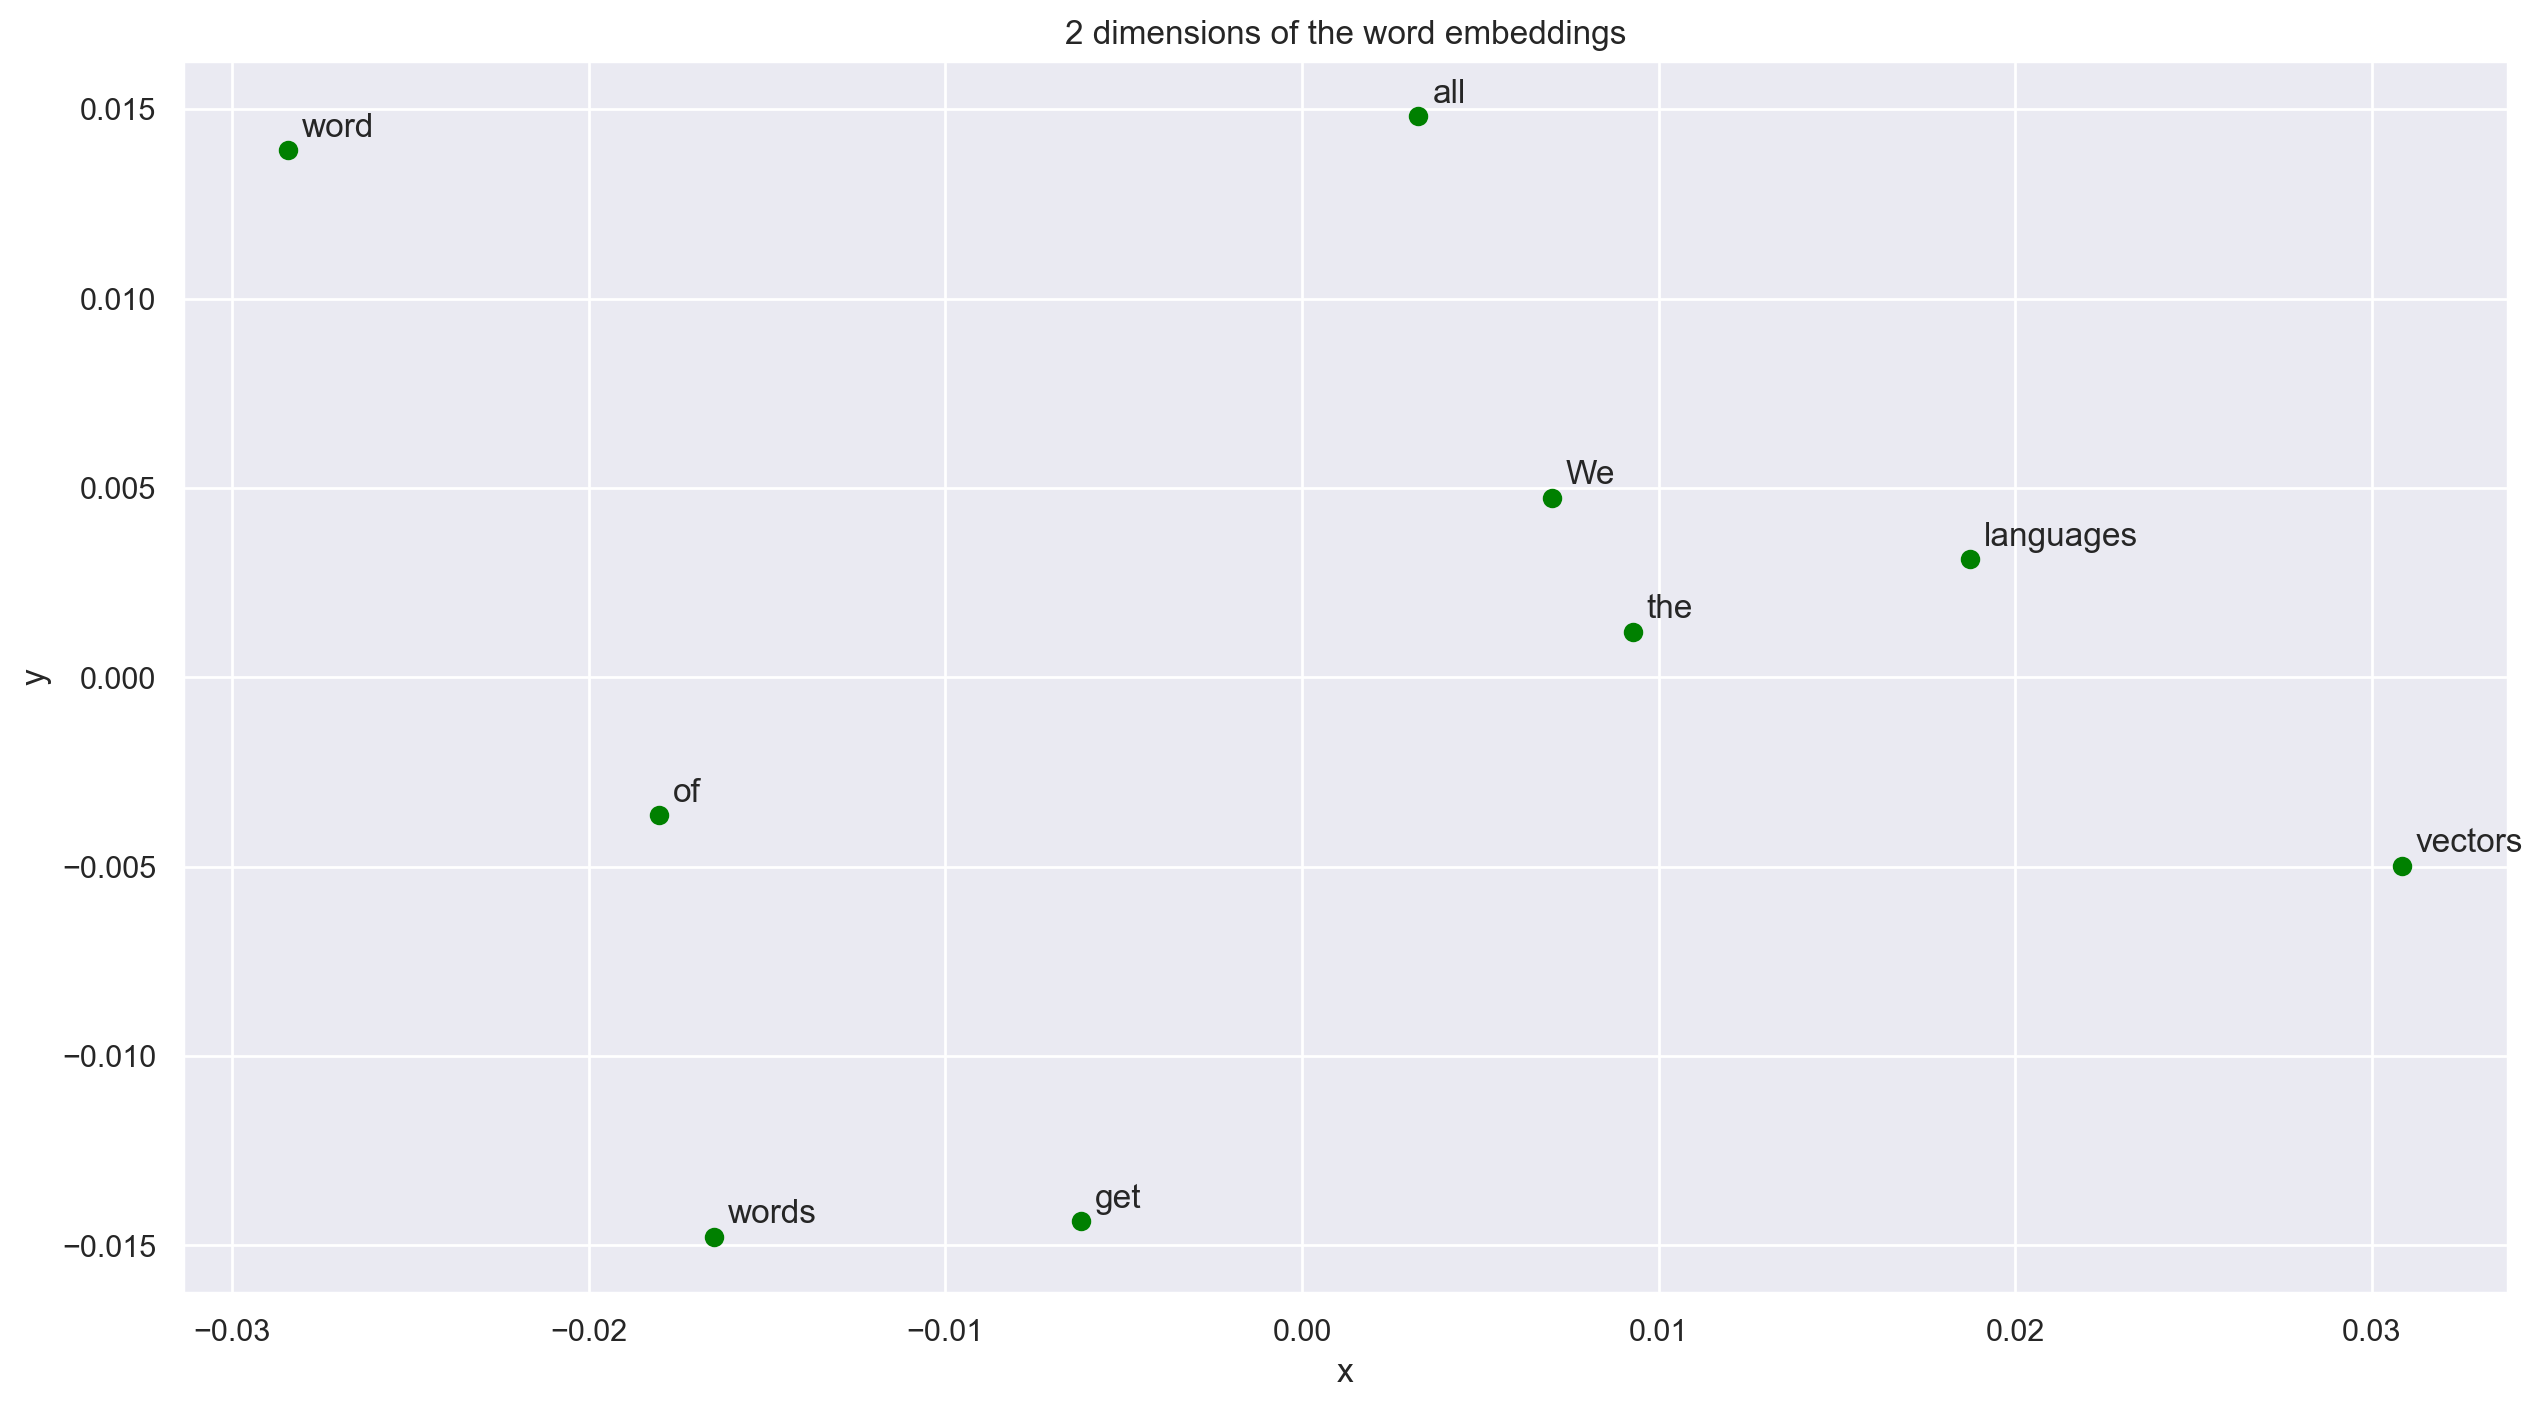

In [25]:
def plot_embedding(vs, ids):
    pca = PCA(n_components=2)
    data = pca.fit_transform(vs).transpose()
    xs, ys = data[0], data[1]
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.scatter(xs, ys, c="green")
    for i, id in enumerate(ids):
        ax.annotate(
            id2tok[id], (xs[i], ys[i]), xytext=(5, 5), textcoords="offset points"
        )
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("2 dimensions of the word embeddings")
    plt.show()


# plotting all the words that have just been initialized:
plot_embedding(parameters["EMBS"], id2tok.keys())

In [26]:
def ind_to_word_embs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained

    🚧 TODO: complete:
    returns a matrix of word vectors as _____m columns with shape _____(emb_size, m = number of input vectors (tokens to update)
    end TODO

    """
    m = inds.shape[1]
    embs = parameters["EMBS"]

    # Select the rows of the embedding matrix corresponding to the indices
    #     flatten() -> 1D array (as many elements as indices)
    w_embs = embs[inds.flatten(), :].T

    assert w_embs.shape == (embs.shape[1], m)

    return w_embs

In [27]:
def linear_dense(w_embs, parameters):
    """
    w_embs: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    returns: ws et zs
    ws: matrix of weights of the dense layer
    zs: output matrix of the dense layer
        🚧 TODO: complete :
        zs is of shape: _____(vocab_size, m = number of input vectors (tokens to update)

    """
    m = w_embs.shape[1]
    ws = parameters["W"]
    zs = np.dot(ws, w_embs)

    assert zs.shape == (ws.shape[0], m)

    return ws, zs

In [28]:
def softmax(zs):
    """
    zs: output out of the dense layer.
        shape: (vocab_size, m = number of input vectors (tokens to update))
    """
    softmax_out = np.divide(
        np.exp(zs), np.sum(np.exp(zs), axis=0, keepdims=True) + EPS
    )
    assert softmax_out.shape == zs.shape

    return softmax_out

In [29]:
def forward_propagation(inds, parameters):
    w_embs = ind_to_word_embs(inds, parameters)
    ws, zs = linear_dense(w_embs, parameters)
    softmax_out = softmax(zs)

    caches = {}
    caches["inds"] = inds
    caches["w_embs"] = w_embs
    caches["W"] = ws
    caches["Z"] = zs
    return softmax_out, caches

In [30]:
def cross_entropy(softmax_out, ys):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m=batch_size)
    ys: ground truth: indices à prédire. shape: (1, m)
    """
    m = softmax_out.shape[1]

    cost = -(1 / m) * np.sum(
        np.log(softmax_out[ys.flatten(), np.arange(ys.shape[1])] + EPS)
    )
    return cost

🚧 TODO, read this carrefully:

* From the softmax out, I select the lines corresponding to the predicted tokens

* It gives me the probabilities, I take the log, and I average it

* If the prediction was perfect, the probability would be 1, the log is 0 --> zero cost

* If not, I have a proba smaller than 1, I take the average of these probas logs (which are all negative)

* With the "$-$" it becomes positive, so it is a measure of the error of the prediction

* Note that `ys` can contain several times the same index to predict. It is counted as many times as it should be predicted.

$$\frac{dL}{dZ} = softmax\_out - ys$$

$$\frac{dL}{dW} = \frac{dL}{dZ}\times\frac{dZ}{dW}= \frac{dL}{dZ}\times w\_embs.T$$

$$ 
\frac{dL}{d w\_embs} = \frac{dL}{dZ}\times\frac{dZ}{d w\_embs}
    = \frac{dL}{dZ} \times W.T
$$

In [31]:
def softmax_backward(ys, softmax_out):
    """
    ys: labels of training data. shape: (1, m=batch_size)
    softmax_out: output out of softmax. shape: (vocab_size, m=batch_size)
    """
    m = ys.shape[1]

    # we compute the difference between the prediction and the ground truth (ys)
    # if the prediction was perfect, the dl_dz becomes 0
    # we only touch the lines to predict
    # if the token is not to be predicted, we do not touch the line
    softmax_out[ys.flatten(), np.arange(m)] -= 1.0
    dl_dz = softmax_out

    assert dl_dz.shape == softmax_out.shape
    return dl_dz

In [32]:
def dense_backward(dl_dz, caches):
    """
    dl_dz: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    dl_dz has negative values where something needs to be changed.
    the more negative they are, the worse it is.
    """
    ws = caches["W"]
    w_embs = caches["w_embs"]
    m = w_embs.shape[1]

    # we multiply where we need to change something:
    # dl_dz.shape = (vocab_size, m)
    dl_dw = (1 / m) * np.dot(dl_dz, w_embs.T)
    dl_dw_embs = np.dot(ws.T, dl_dz)

    assert ws.shape == dl_dw.shape
    assert w_embs.shape == dl_dw_embs.shape

    return dl_dw, dl_dw_embs

In [33]:
def backward_propagation(ys, softmax_out, caches):
    dl_dz = softmax_backward(ys, softmax_out)
    dl_dw, dl_dw_embs = dense_backward(dl_dz, caches)

    gradients = dict()
    gradients["dL_dZ"] = dl_dz
    gradients["dL_dW"] = dl_dw
    gradients["dL_dw_embs"] = dl_dw_embs

    return gradients

In [34]:
def update_parameters(parameters, caches, gradients, learning_rate):
    """
    here we update the embedding
    """
    vocab_size, emb_size = parameters["EMBS"].shape
    inds = caches["inds"]
    embs = parameters["EMBS"]
    dl_dw_embs = gradients["dL_dw_embs"]
    m = inds.shape[-1]

    # note that only the lines corresponding to the central words are modified
    embs[inds.flatten(), :] -= dl_dw_embs.T * learning_rate

    parameters["W"] -= learning_rate * gradients["dL_dW"]

In [35]:
def skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size,
    learning_rate,
    epochs,
    batch_size=256,
    parameters=None,
    print_cost=False,
    plot_cost=True,
):
    costs = []
    m = xs.shape[1]

    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)

    # 🚧 TODO: use these three variables to keep the best model at the end
    best_epoch = 0
    min_epoch_cost = float("inf")
    parameters["best_embeddings"] = parameters["EMBS"]

    begin_time = datetime.now()
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = xs[:, i : i + batch_size]
            Y_batch = ys[:, i : i + batch_size]

            softmax_out, caches = forward_propagation(X_batch, parameters)
            cost = cross_entropy(softmax_out, Y_batch)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            epoch_cost += cost

        costs.append(epoch_cost)
        # 🚧 TODO: add here the code to keep the best_embeddings
        if epoch_cost < min_epoch_cost:
            best_epoch = epoch
            min_epoch_cost = epoch_cost
            parameters["best_embeddings"] = parameters["EMBS"]
        # end TODO

        if print_cost and epoch % 200 == 0:
            print(f"Cost after epoch {epoch:4d}: {epoch_cost:.4f}")
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
    end_time = datetime.now()
    
    print(f"training time: {end_time - begin_time}")
    print(
        f"🚧 TODO I've kept the embedding of epoch {best_epoch} "
        f"with cost {min_epoch_cost:.4f}."
    )
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel("# of epochs")
        plt.ylabel("cost")
    return parameters

In [36]:
print(ys.shape, xs.shape, one_hot_ys.shape)

(1, 72) (1, 72) (9, 72)


Cost after epoch    0: 2.1973
Cost after epoch  200: 2.1288
Cost after epoch  400: 2.0608
Cost after epoch  600: 2.0333
Cost after epoch  800: 2.0206
Cost after epoch 1000: 2.0150
Cost after epoch 1200: 2.0114
Cost after epoch 1400: 2.0100
Cost after epoch 1600: 2.0113
Cost after epoch 1800: 2.0143
Cost after epoch 2000: 2.0175
Cost after epoch 2200: 2.0200
Cost after epoch 2400: 2.0216
Cost after epoch 2600: 2.0224
Cost after epoch 2800: 2.0227
training time: 0:00:00.248730
🚧 TODO I've kept the embedding of epoch 1398 with cost 2.0100.


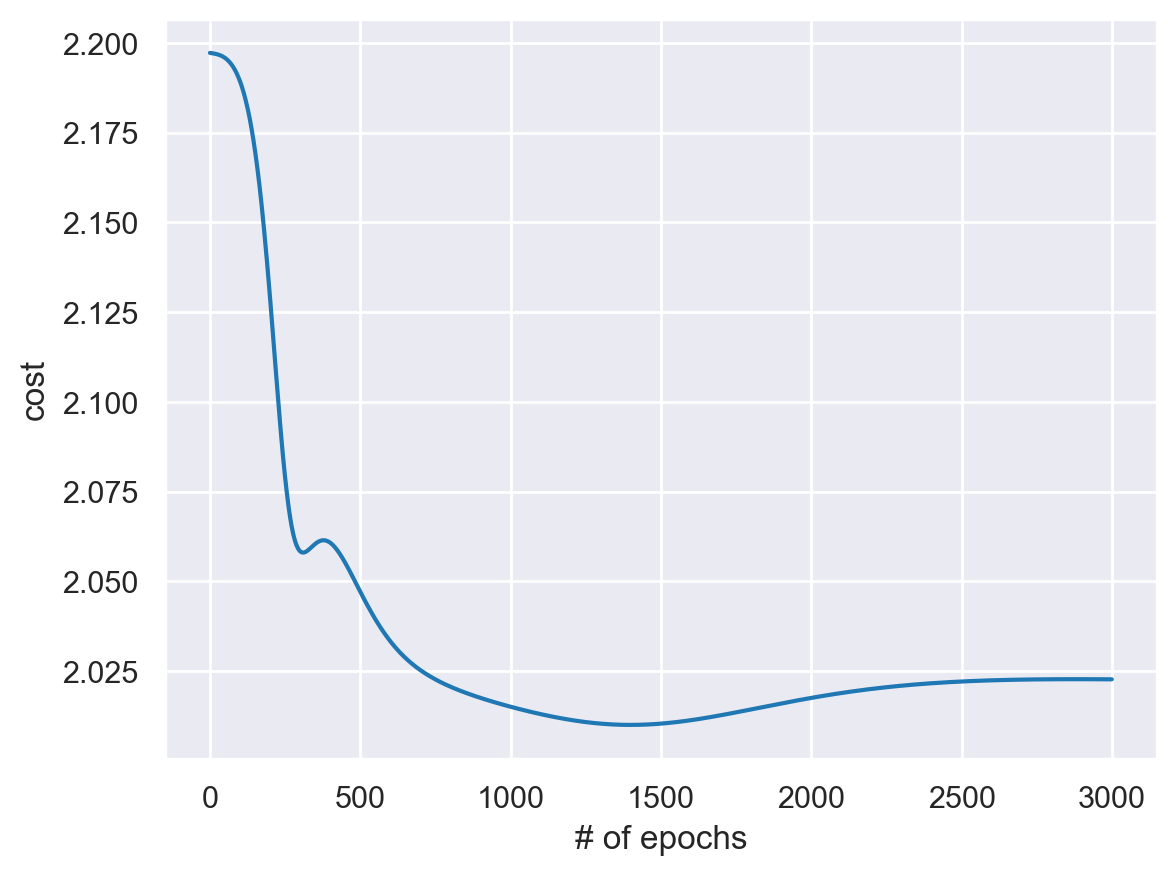

In [37]:
parameters = skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size=50,
    learning_rate=0.05,
    epochs=3000,
    batch_size=128,
    parameters=None,
    print_cost=True,
)
# test with a small batch_size to see....

####  🚧 TODO:

- Keep the best model

- Visualize also the best model

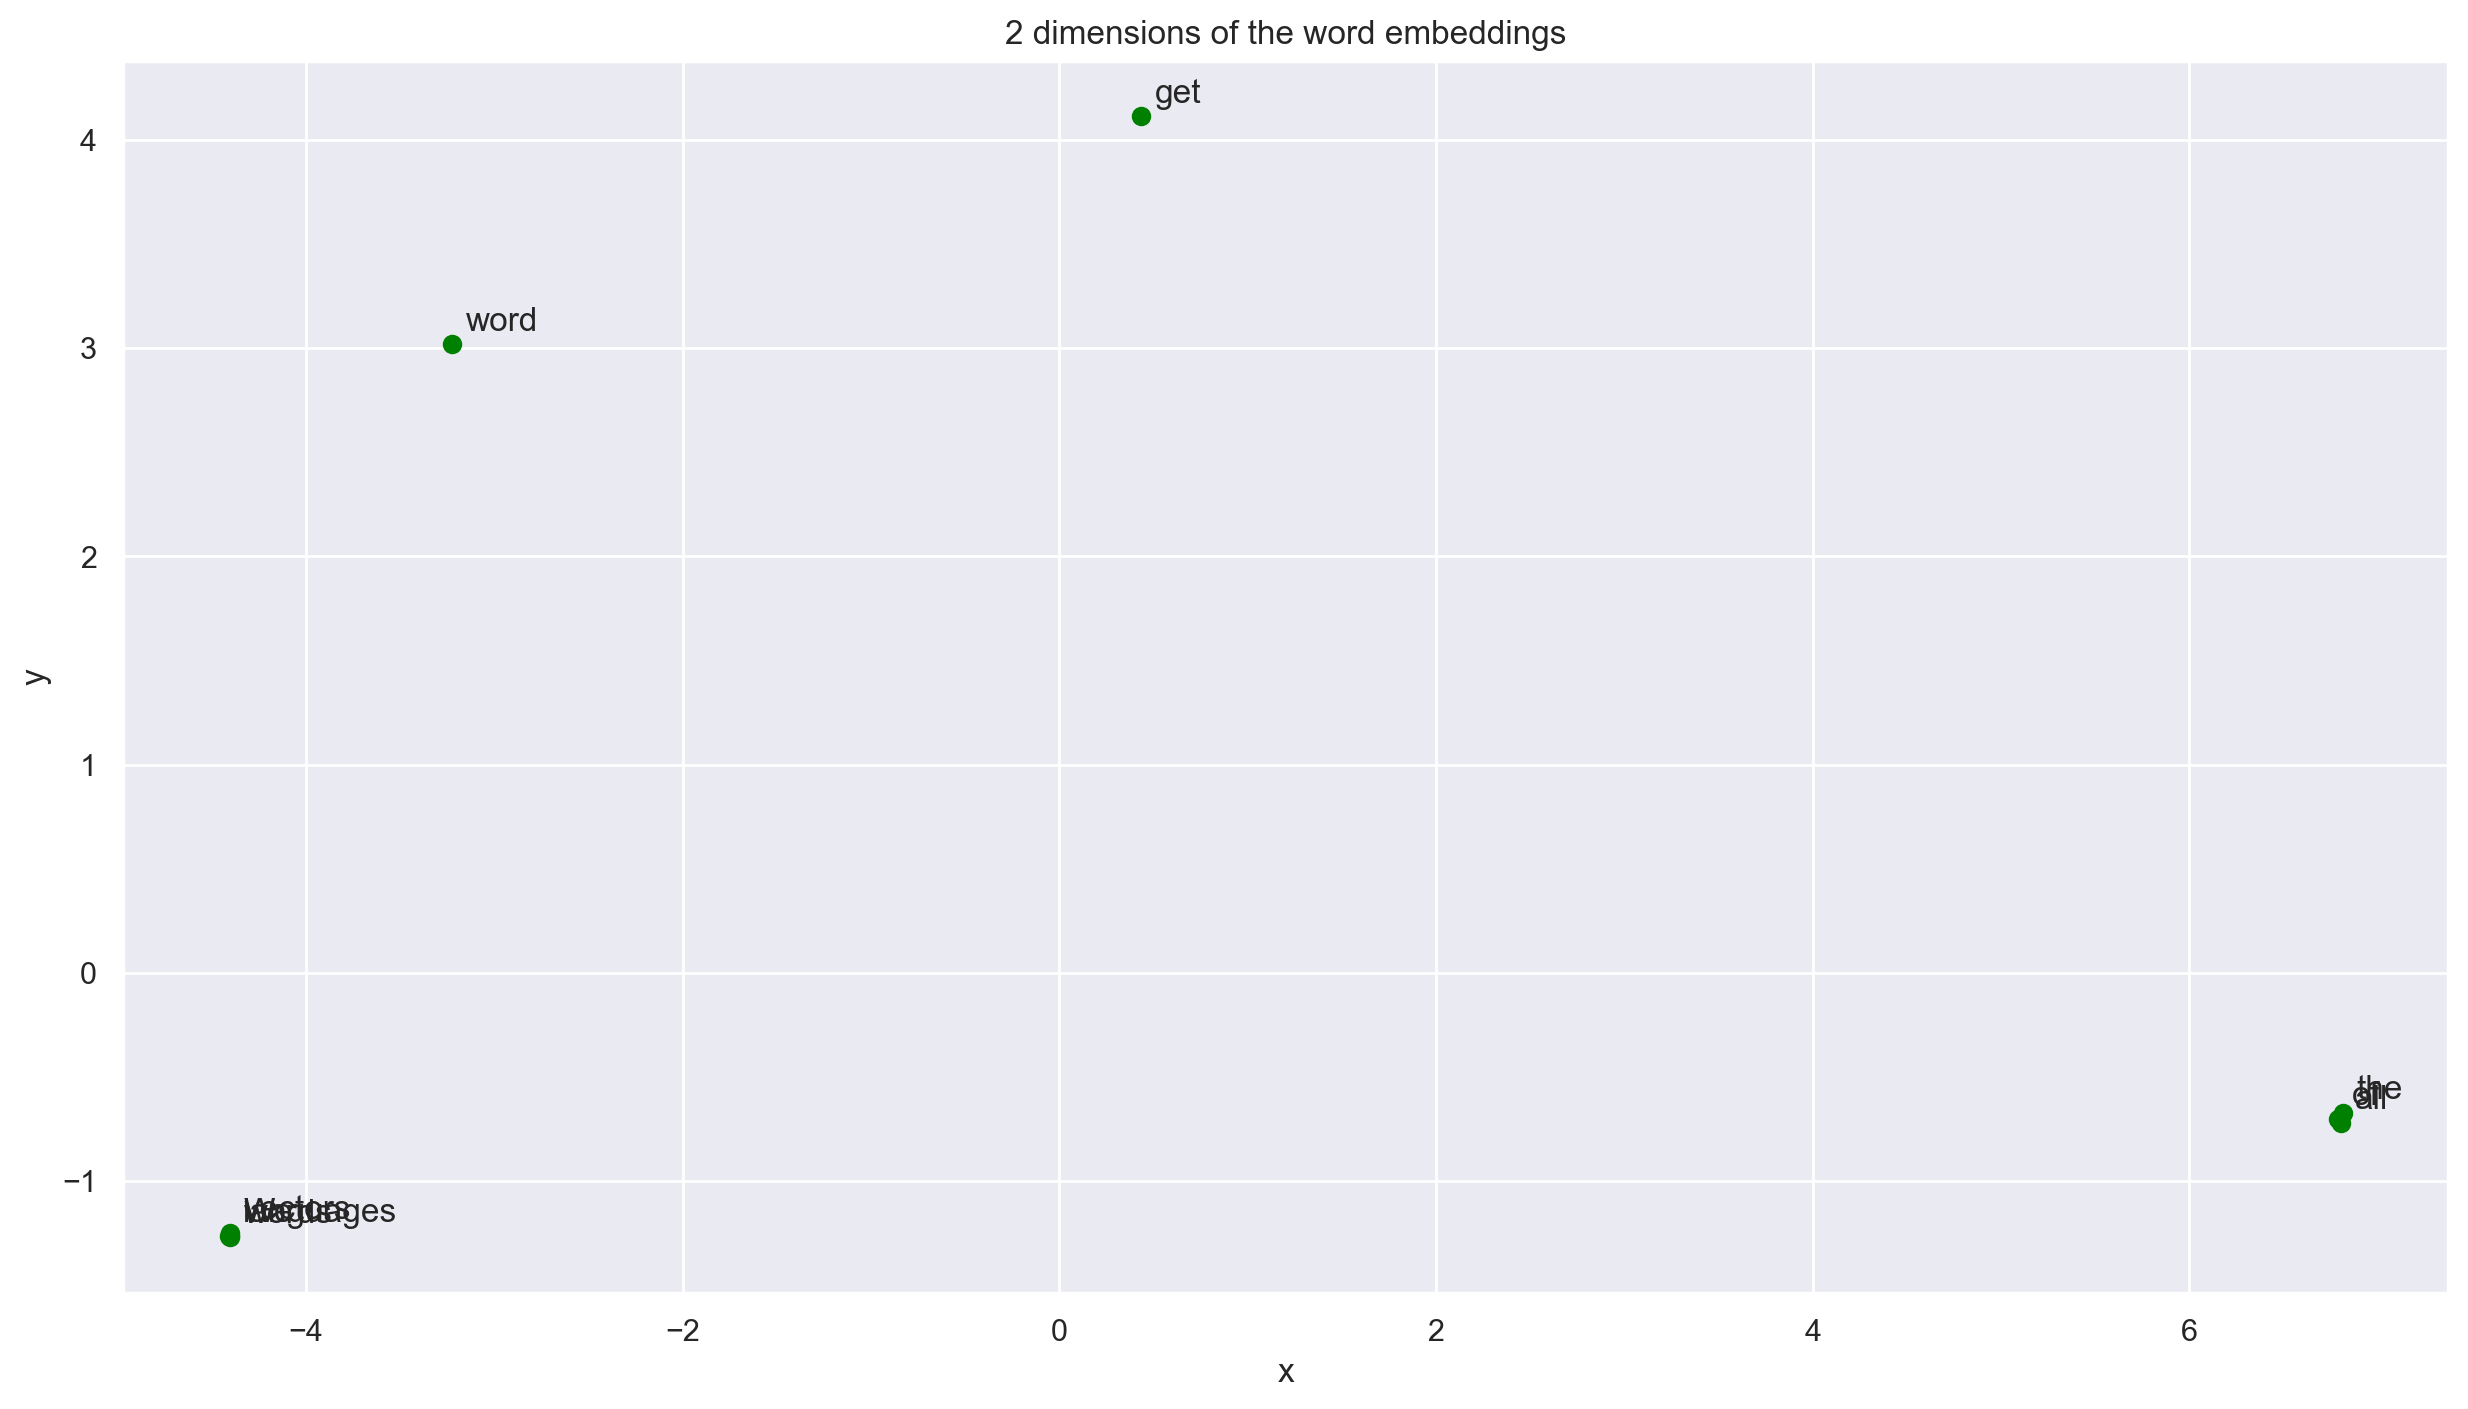

In [38]:
#Keep the best model
parameters["EMBS"] = parameters["best_embeddings"]

#Visualize also the best model
plot_embedding(parameters["best_embeddings"], id2tok.keys())

### First intrinsic evaluation

- Let's take the indices of all the words

- Send them into the grinder

- See if the system can predict the words that were close as the most probable

In [39]:
test_xs = np.arange(vocab_size)
print(test_xs, test_xs.shape)
test_xs = np.expand_dims(test_xs, axis=0)
print(test_xs, test_xs.shape)

# 🚧 TODO: complete

# send test_xs to the forward_propagation
softmax_test, _ = forward_propagation(test_xs, parameters)
# find the 5 most likely indices:
print(softmax_test)
top_sorted_inds = np.argsort(softmax_test, axis=0)[:5]

# end TODO

top_sorted_inds

[0 1 2 3 4 5 6 7 8] (9,)
[[0 1 2 3 4 5 6 7 8]] (1, 9)
[[0.06200884 0.06175146 0.06170387 0.27901107 0.20863439 0.20995509
  0.27879954 0.27880626 0.27897656]
 [0.08645352 0.08537893 0.08538457 0.28865007 0.1865123  0.0584685
  0.28820939 0.28866189 0.28867011]
 [0.09555274 0.09485992 0.09489146 0.17849303 0.00405103 0.05290629
  0.17840049 0.17878076 0.1786402 ]
 [0.11421884 0.11408182 0.11343583 0.04009733 0.2607702  0.12498029
  0.04013509 0.04005915 0.04010714]
 [0.08651375 0.08558161 0.08613127 0.06840788 0.02570863 0.2119888
  0.06818629 0.06819077 0.06838262]
 [0.11522055 0.1148799  0.11386081 0.0744056  0.23773392 0.06704679
  0.07472315 0.07424319 0.07443916]
 [0.13911659 0.14037454 0.14198151 0.01293736 0.02869081 0.15491986
  0.01314962 0.01307221 0.01294271]
 [0.17057624 0.17256871 0.172025   0.02444562 0.01948514 0.03744027
  0.02464963 0.02455429 0.02431838]
 [0.13033893 0.13052311 0.13058568 0.03355203 0.02841359 0.08229411
  0.03374681 0.03363148 0.03352312]]


array([[0, 0, 0, 6, 2, 7, 6, 6, 6],
       [1, 1, 1, 7, 7, 2, 7, 7, 7],
       [4, 4, 4, 8, 4, 1, 8, 8, 8],
       [2, 2, 2, 3, 8, 5, 3, 3, 3],
       [3, 3, 3, 4, 6, 8, 4, 4, 4]])

In [40]:
for input_ind in range(vocab_size):
    input_word = id2tok[input_ind]
    output_words = [
        id2tok[output_ind] for output_ind in top_sorted_inds[::-1, input_ind] # ::-1 means we reverse the order of top_sorted_inds
    ]  # explain ::-1 in few words
    print(f"{input_word}'s neighbor words: {output_words}")

all's neighbor words: ['We', 'of', 'get', 'the', 'all']
the's neighbor words: ['We', 'of', 'get', 'the', 'all']
of's neighbor words: ['We', 'of', 'get', 'the', 'all']
We's neighbor words: ['get', 'We', 'languages', 'words', 'vectors']
get's neighbor words: ['vectors', 'languages', 'get', 'words', 'of']
word's neighbor words: ['languages', 'word', 'the', 'of', 'words']
vectors's neighbor words: ['get', 'We', 'languages', 'words', 'vectors']
words's neighbor words: ['get', 'We', 'languages', 'words', 'vectors']
languages's neighbor words: ['get', 'We', 'languages', 'words', 'vectors']


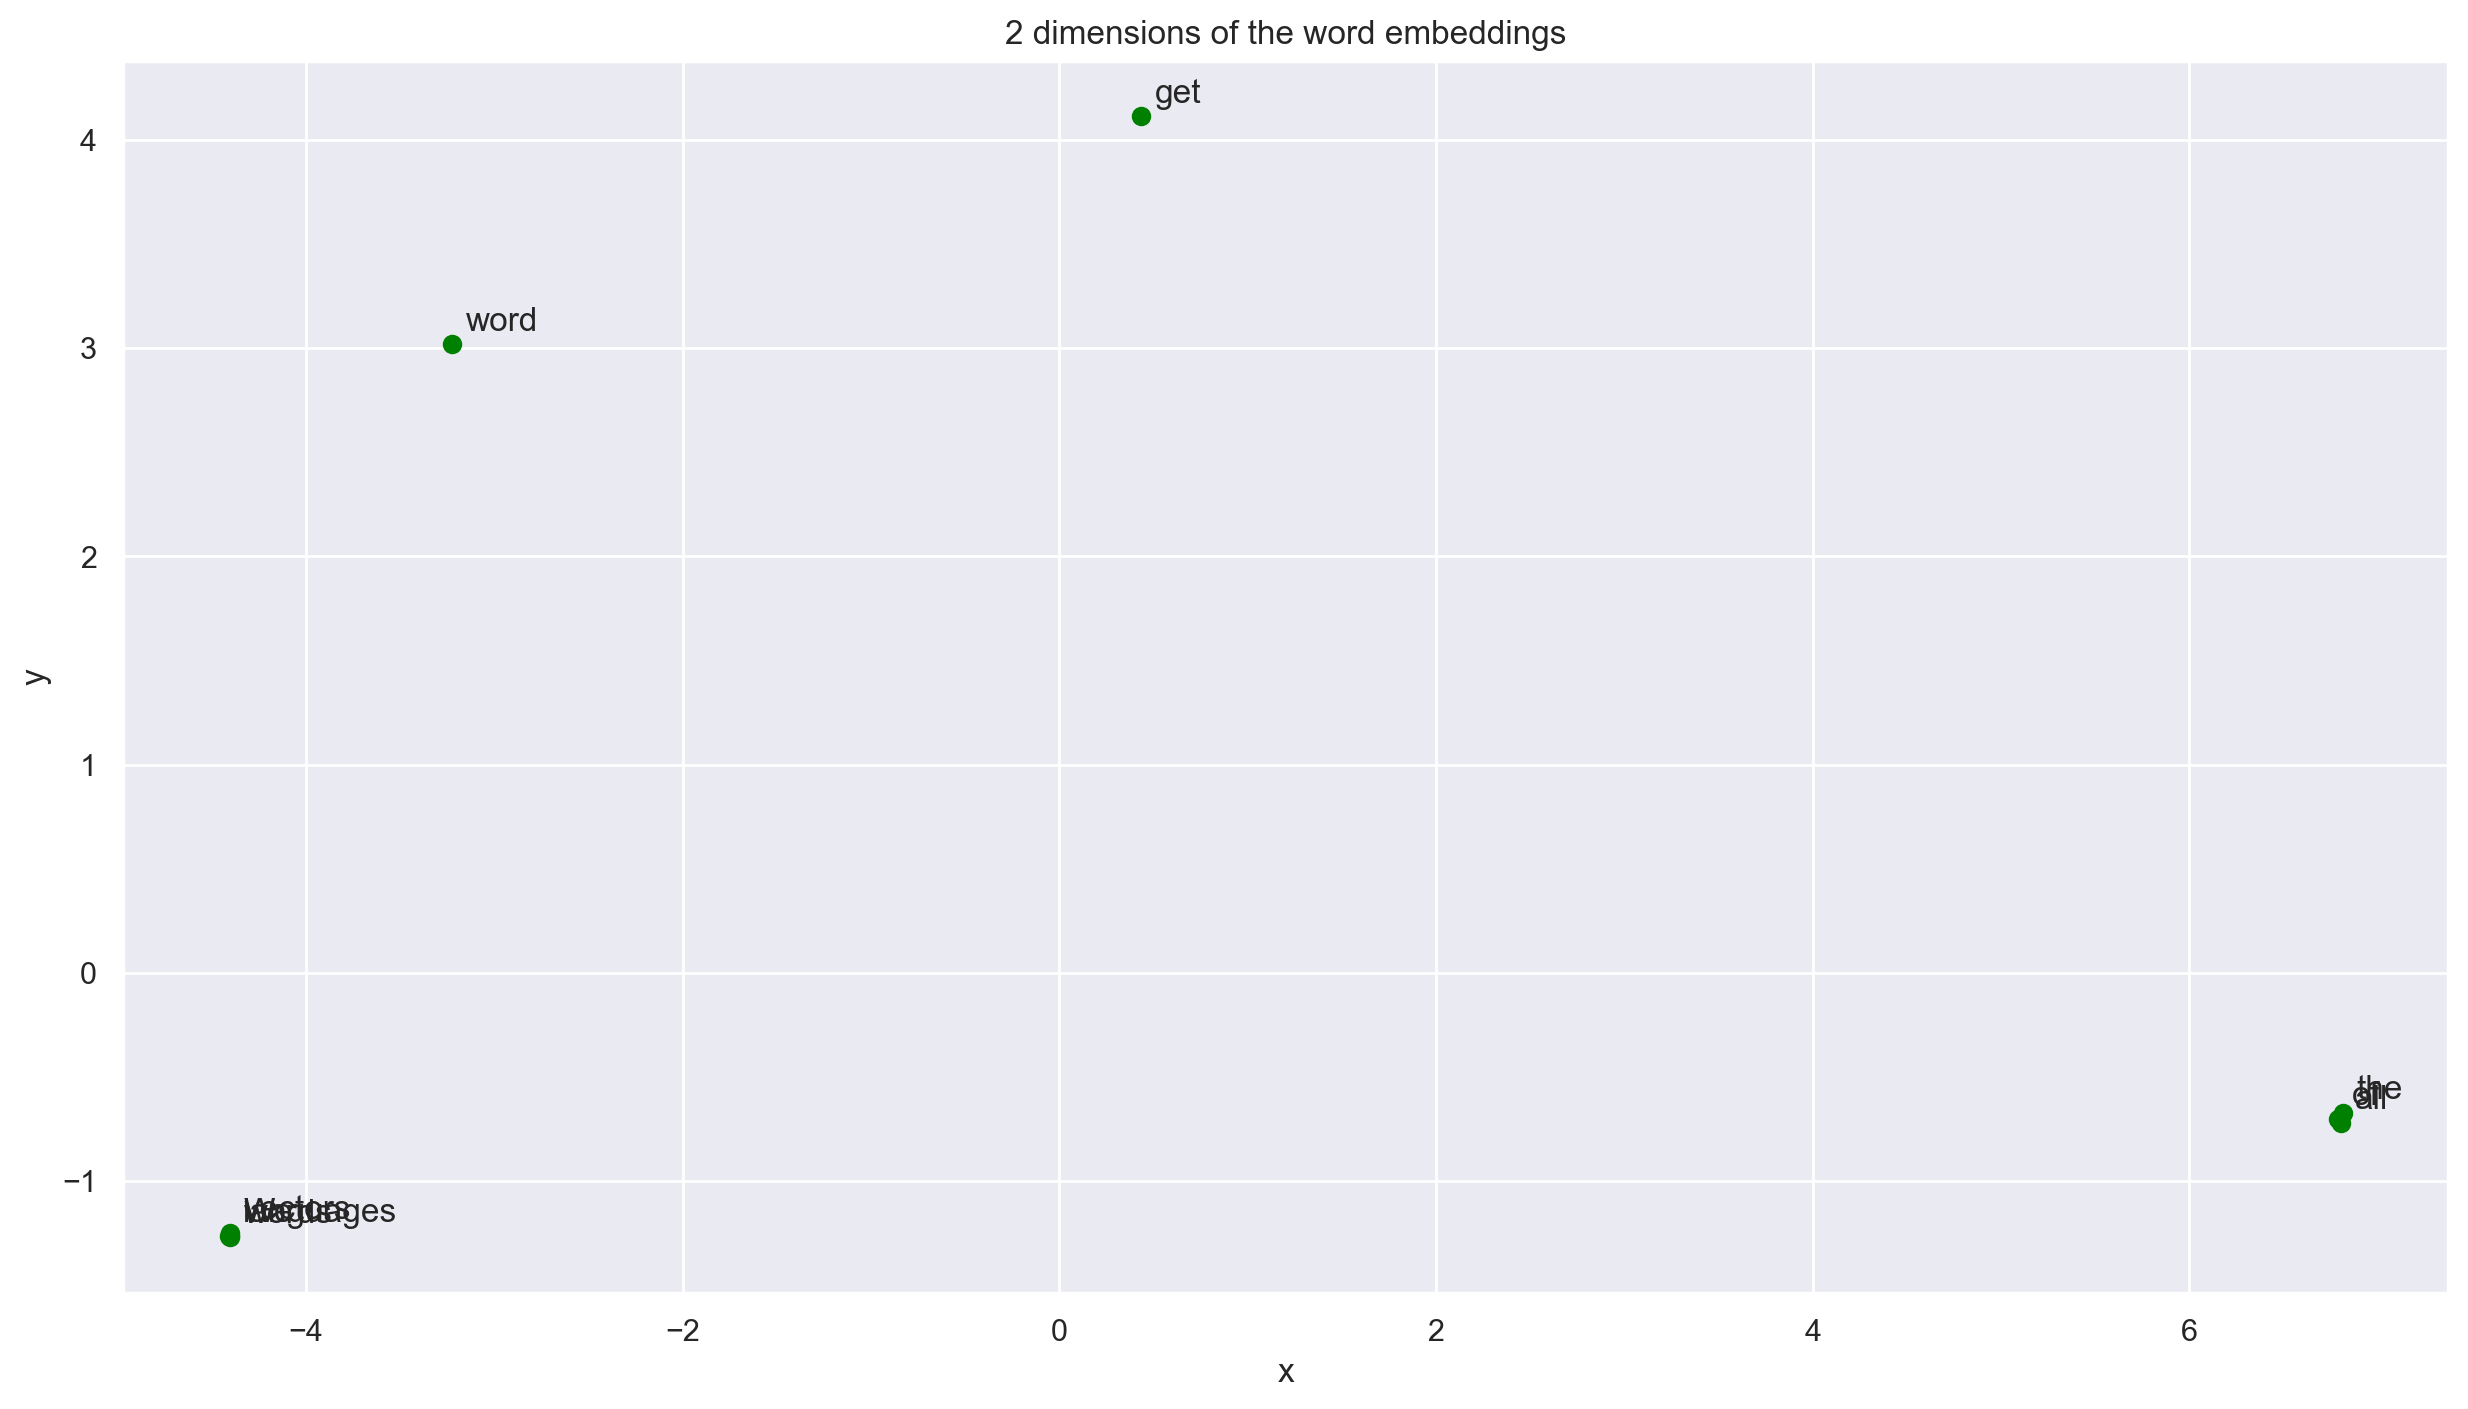

In [41]:
plot_embedding(parameters["best_embeddings"], test_xs[0])

In [42]:
parameters["best_embeddings"].shape

(9, 50)

In [43]:
# Let's calculate the cosine distance between all words

cos_dists = scipy.spatial.distance.cdist(
    parameters["best_embeddings"], parameters["best_embeddings"], "cosine"
)
print(cos_dists.shape)
print(id2tok.values())

(9, 9)
dict_values(['all', 'the', 'of', 'We', 'get', 'word', 'vectors', 'words', 'languages'])


In [44]:
def costs_heatmap(costs, id2tok):
    plt.figure(figsize=(9, 8))
    sns.heatmap(
        costs, 
        annot=costs.round(1),
        xticklabels=id2tok.values(), 
        yticklabels=id2tok.values(), 
        cmap="RdPu",
    )

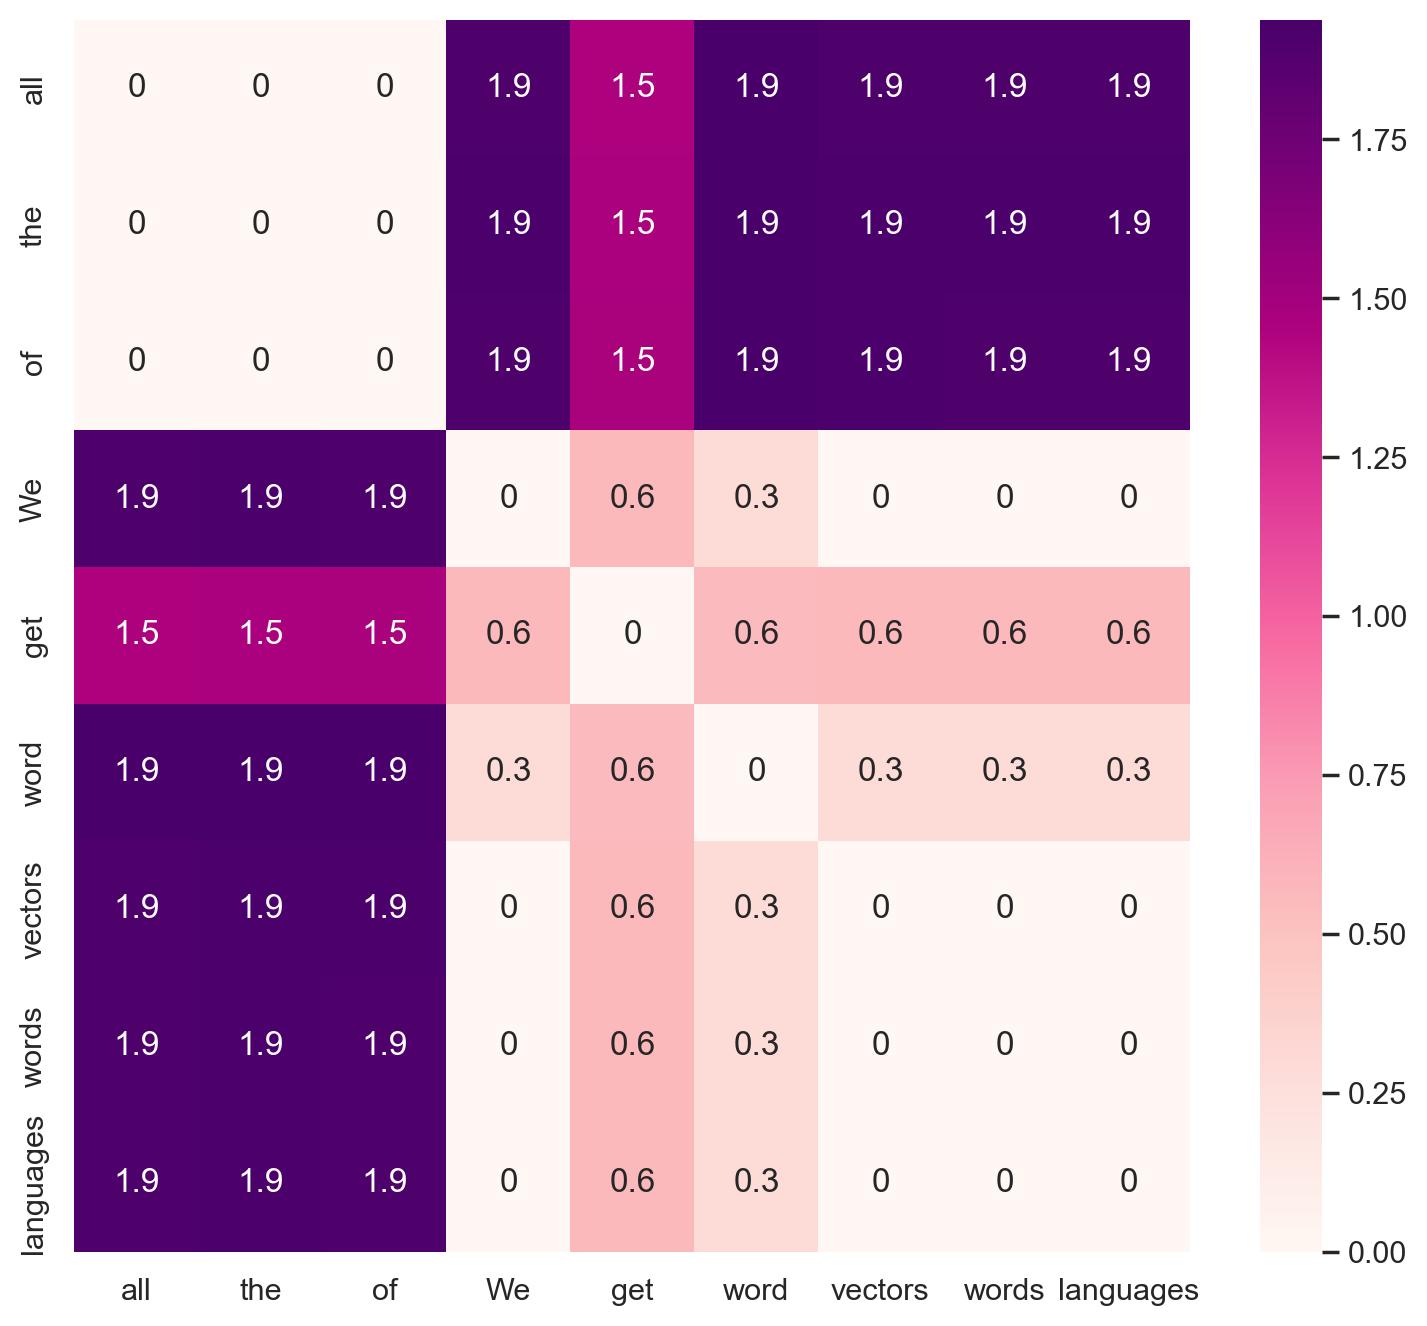

In [45]:
costs_heatmap(cos_dists, id2tok)

### 🚧 attempt a short hande-waving explanations of what you see in the heatmap

<font color=orange>  

'languages', 'words', 'vectors', 'We' are similar;  

'all', 'the', 'of' are similar;  

The distances between these two group of words are big;

'get' and 'word' are another two different groups;

The distribution of these four groups are as same as the plot '2 dimensions of the word embddings'
<font>

## A longer text

In [46]:
text = """The celestial sphere is an imaginary projection of the Sun, Moon,
planets, stars, and all astronomical bodies upon an imaginary sphere surrounding
Earth. Although originally developed as part of the ancient Greek concept of an
Earth-centered (geocentric) universe, the hypothetical celestial sphere gives
astronomers an important tool for fixing the location and plotting movements of
celestial objects. Ancient Greek astronomers envisioned concentric crystalline
spheres centered around Earth, upon which the Sun, Moon, planets, and stars
moved. Although heliocentric (Sun-centered) models of the universe were also
proposed by the Greeks, they were disregarded as counterintuitive to the
apparent motions of celestial bodies across the sky. Corresponding to Earth’s
rotation, the celestial sphere rotates through 1° in about four minutes. Because
of this, sunrise, sunset, moonrise, and moon-set, all take approximately two
minutes because both the Sun and Moon have the same apparent size on the
celestial sphere (about 0.5°). The Sun is, of course, much larger, but the Moon
is much closer. """

### Do the same thing again

for this larger text

In [47]:
tokens = tokenize(text)
print(Counter(tokens))

# 🚧 TODO: complete
tok2id, id2tok = mapping(tokens)
xs, ys = generate_training_data_skip(tokens, 3)
# end TODO
xs, ys = np.array(xs), np.array(ys)
vocab_size = len(id2tok)

m = ys.shape[1]
print("m:", m)

Counter({'the': 14, 'of': 8, 'celestial': 6, 'sphere': 5, 'and': 5, 'an': 4, 'Sun': 4, 'Moon': 4, 'is': 3, 'Earth': 3, 'The': 2, 'imaginary': 2, 'planets': 2, 'stars': 2, 'all': 2, 'bodies': 2, 'upon': 2, 'Although': 2, 'as': 2, 'Greek': 2, 'universe': 2, 'astronomers': 2, 'were': 2, 'to': 2, 'apparent': 2, 'about': 2, 'minutes': 2, 'much': 2, 'projection': 1, 'astronomical': 1, 'surrounding': 1, 'originally': 1, 'developed': 1, 'part': 1, 'ancient': 1, 'concept': 1, 'Earth-centered': 1, 'geocentric': 1, 'hypothetical': 1, 'gives': 1, 'important': 1, 'tool': 1, 'for': 1, 'fixing': 1, 'location': 1, 'plotting': 1, 'movements': 1, 'objects': 1, 'Ancient': 1, 'envisioned': 1, 'concentric': 1, 'crystalline': 1, 'spheres': 1, 'centered': 1, 'around': 1, 'which': 1, 'moved': 1, 'heliocentric': 1, 'Sun-centered': 1, 'models': 1, 'also': 1, 'proposed': 1, 'by': 1, 'Greeks': 1, 'they': 1, 'disregarded': 1, 'counterintuitive': 1, 'motions': 1, 'across': 1, 'sky': 1, 'Corresponding': 1, 's': 1, '

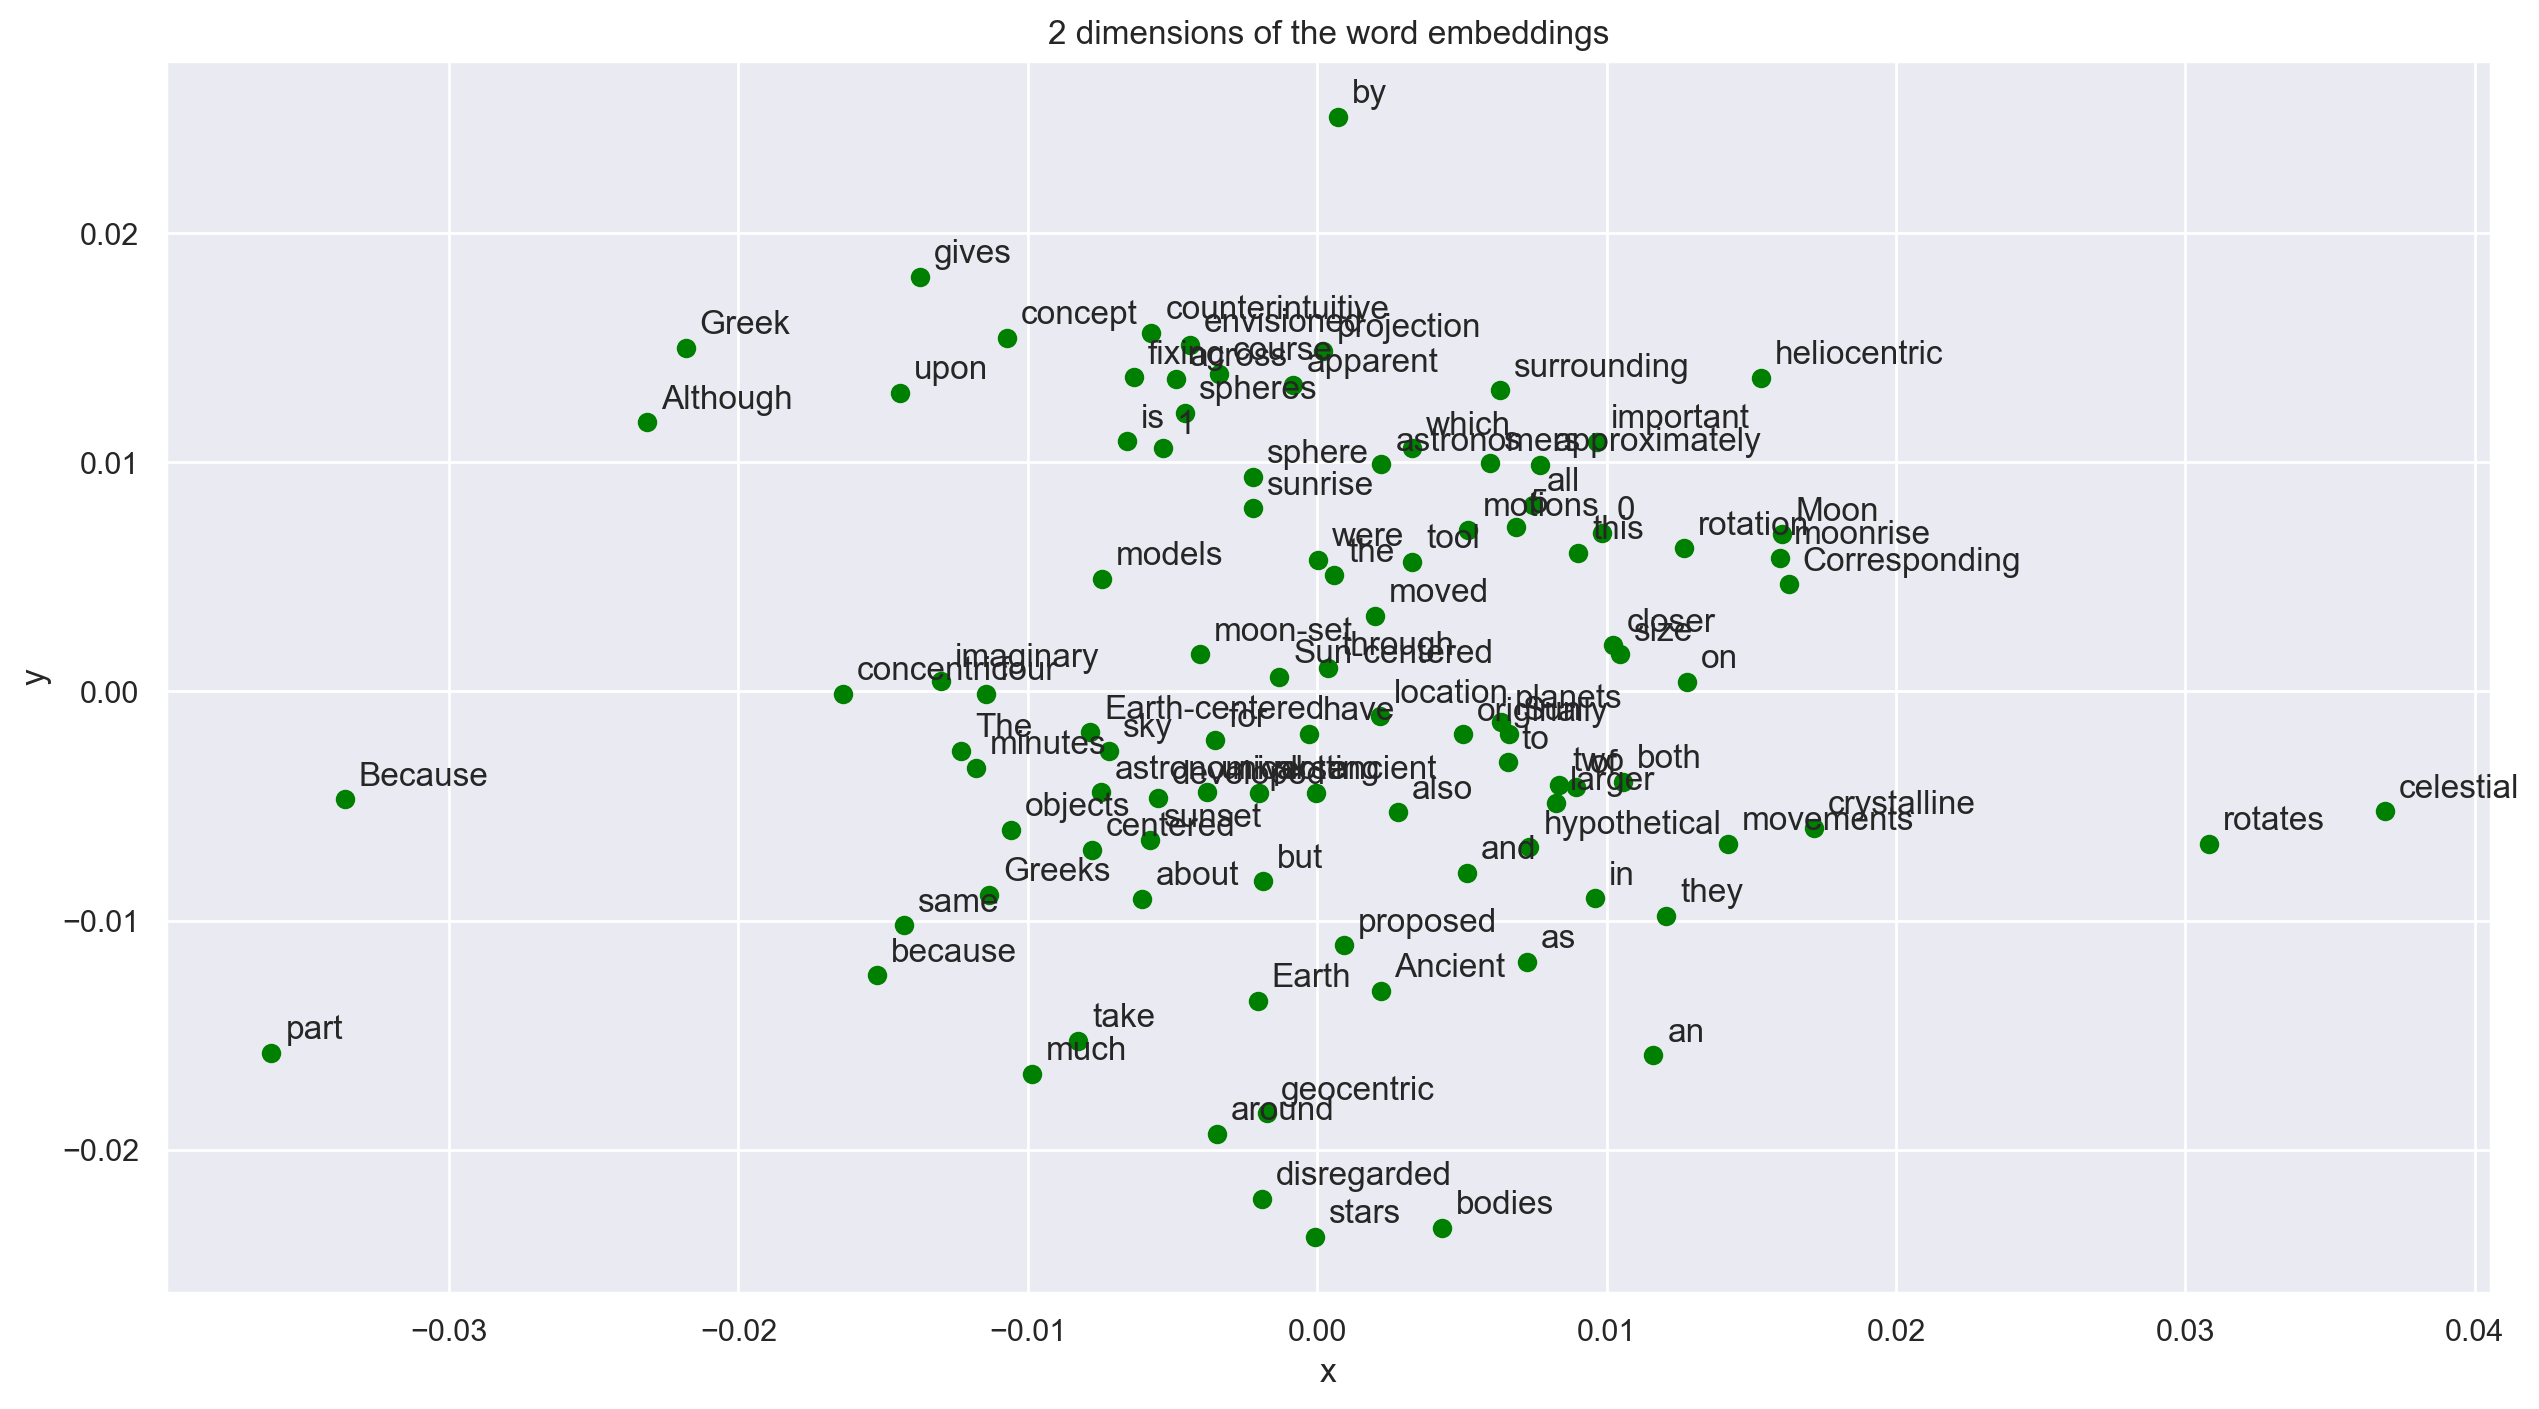

In [48]:
# TODO: initialize the parameters and visualize the distribution (normal, random)
parameters = initialize_parameters(len(tok2id), 5)
plot_embedding(parameters["EMBS"], id2tok.keys())

Cost after epoch    0: 36.7610
Cost after epoch  200: 34.8902
Cost after epoch  400: 29.6968
Cost after epoch  600: 27.2015
Cost after epoch  800: 26.5401
Cost after epoch 1000: 26.3340
Cost after epoch 1200: 26.1382
Cost after epoch 1400: 26.1384
Cost after epoch 1600: 26.2634
Cost after epoch 1800: 26.1899
Cost after epoch 2000: 26.1083
Cost after epoch 2200: 26.1712
Cost after epoch 2400: 26.1921
Cost after epoch 2600: 26.1056
Cost after epoch 2800: 26.0294
Cost after epoch 3000: 26.0246
Cost after epoch 3200: 26.0740
Cost after epoch 3400: 26.1465
Cost after epoch 3600: 26.1861
Cost after epoch 3800: 26.1857
Cost after epoch 4000: 26.1519
Cost after epoch 4200: 26.1152
Cost after epoch 4400: 26.0799
Cost after epoch 4600: 26.0536
Cost after epoch 4800: 26.0365
training time: 0:00:47.563029
🚧 TODO I've kept the embedding of epoch 2916 with cost 26.0090.


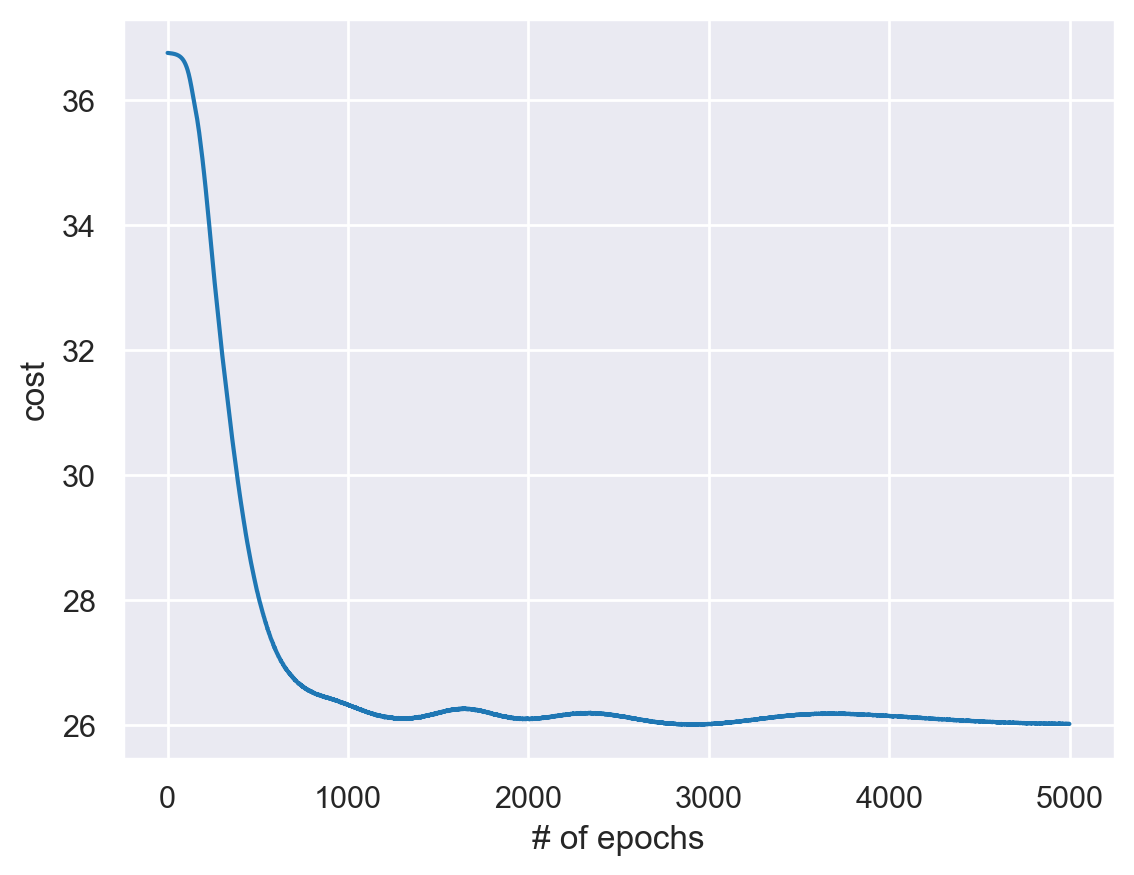

In [49]:
# Be patient:
parameters = skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size=50,
    learning_rate=0.05,
    epochs=5000,
    batch_size=128,
    parameters=None,
    print_cost=True,
)

In [50]:
# 🚧 TODO: as before find the predicted words from the context
parameters["EMBS"] = parameters["best_embeddings"]
test_xs = np.arange(vocab_size)
test_xs = np.expand_dims(test_xs, axis=0)
softmax_test, _ = forward_propagation(test_xs, parameters)
top_sorted_inds = np.argsort(softmax_test, axis=0)[:5]
for input_ind in range(10):
    input_word = id2tok[input_ind]
    output_words = [
        id2tok[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]
    ]
    print(f"{input_word}'s neighbor words: {output_words}")

the's neighbor words: ['The', 'disregarded', 'important', 'spheres', 'originally']
of's neighbor words: ['sphere', 'upon', 'but', 'of', 'Earth']
celestial's neighbor words: ['minutes', 'Moon', 'but', 'Sun', 'much']
sphere's neighbor words: ['apparent', 'Sun', 'bodies', 'tool', 'Greek']
and's neighbor words: ['but', 'The', 'much', '0', '5']
an's neighbor words: ['objects', '5', 'The', 'sunrise', 'minutes']
Sun's neighbor words: ['imaginary', 'an', 'Ancient', 'about', 'celestial']
Moon's neighbor words: ['crystalline', 'projection', 'The', '5', 'course']
is's neighbor words: ['centered', 'rotation', 'around', 'upon', 'Earth']
Earth's neighbor words: ['minutes', 'about', 'Greek', '5', 'tool']


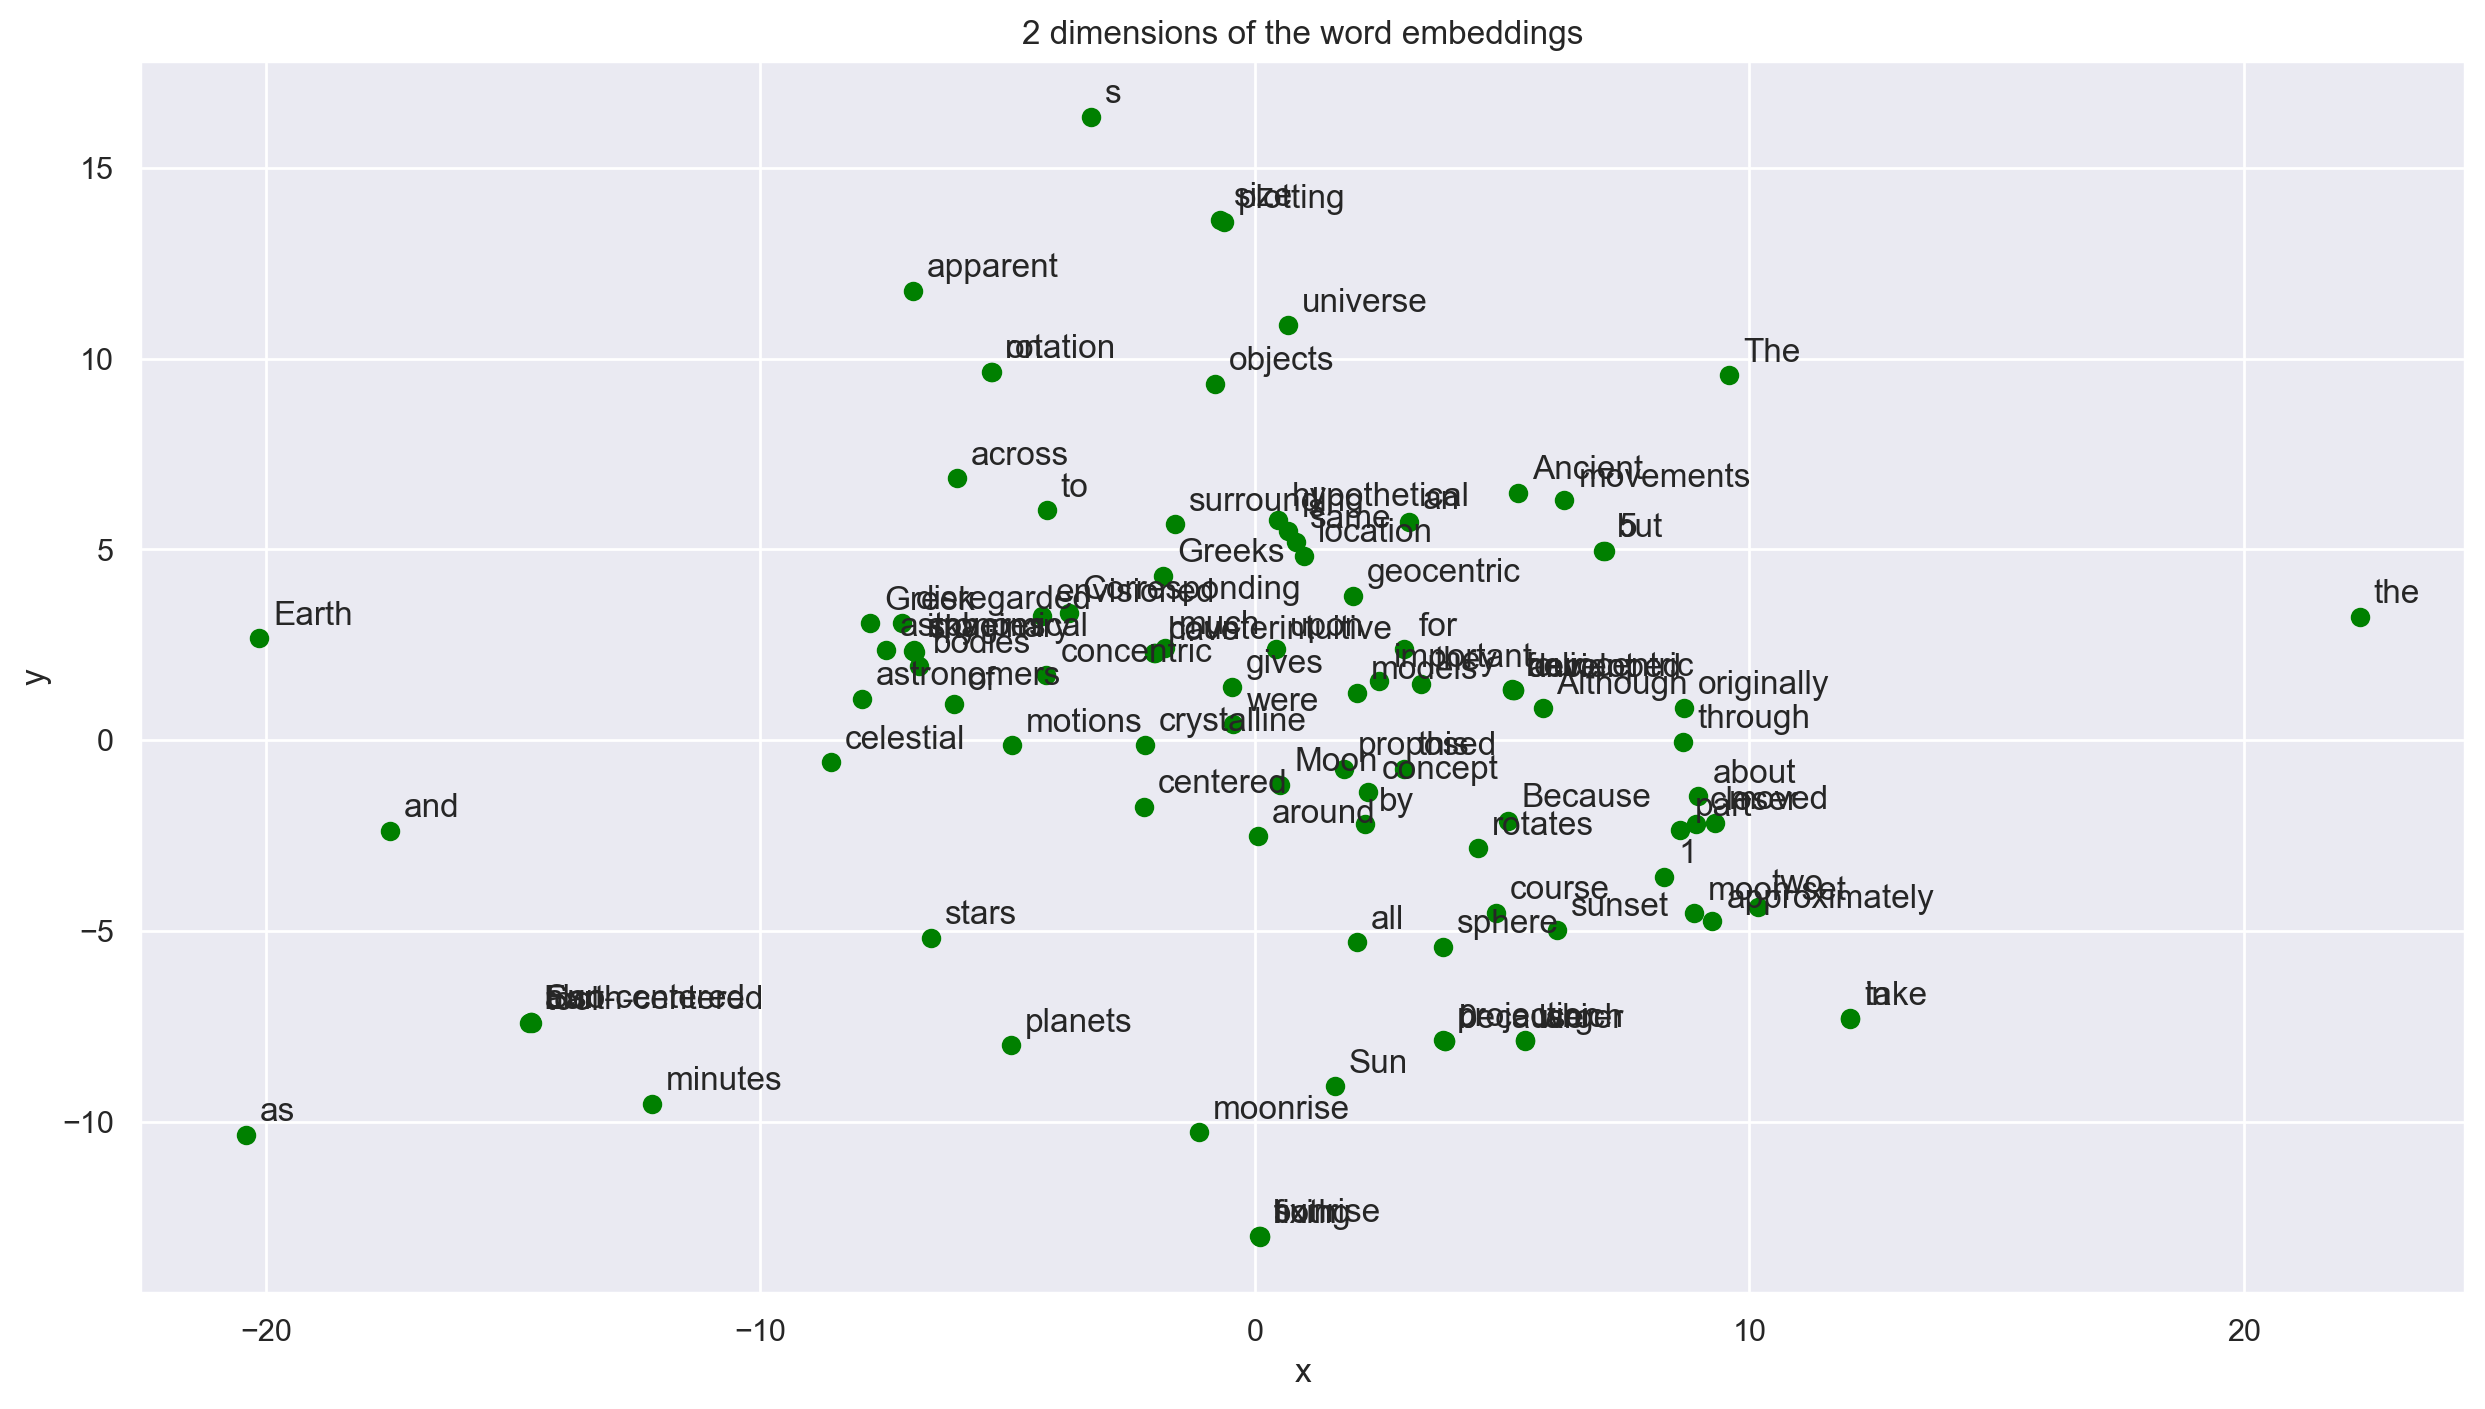

In [51]:
plot_embedding(parameters["EMBS"], id2tok.keys())

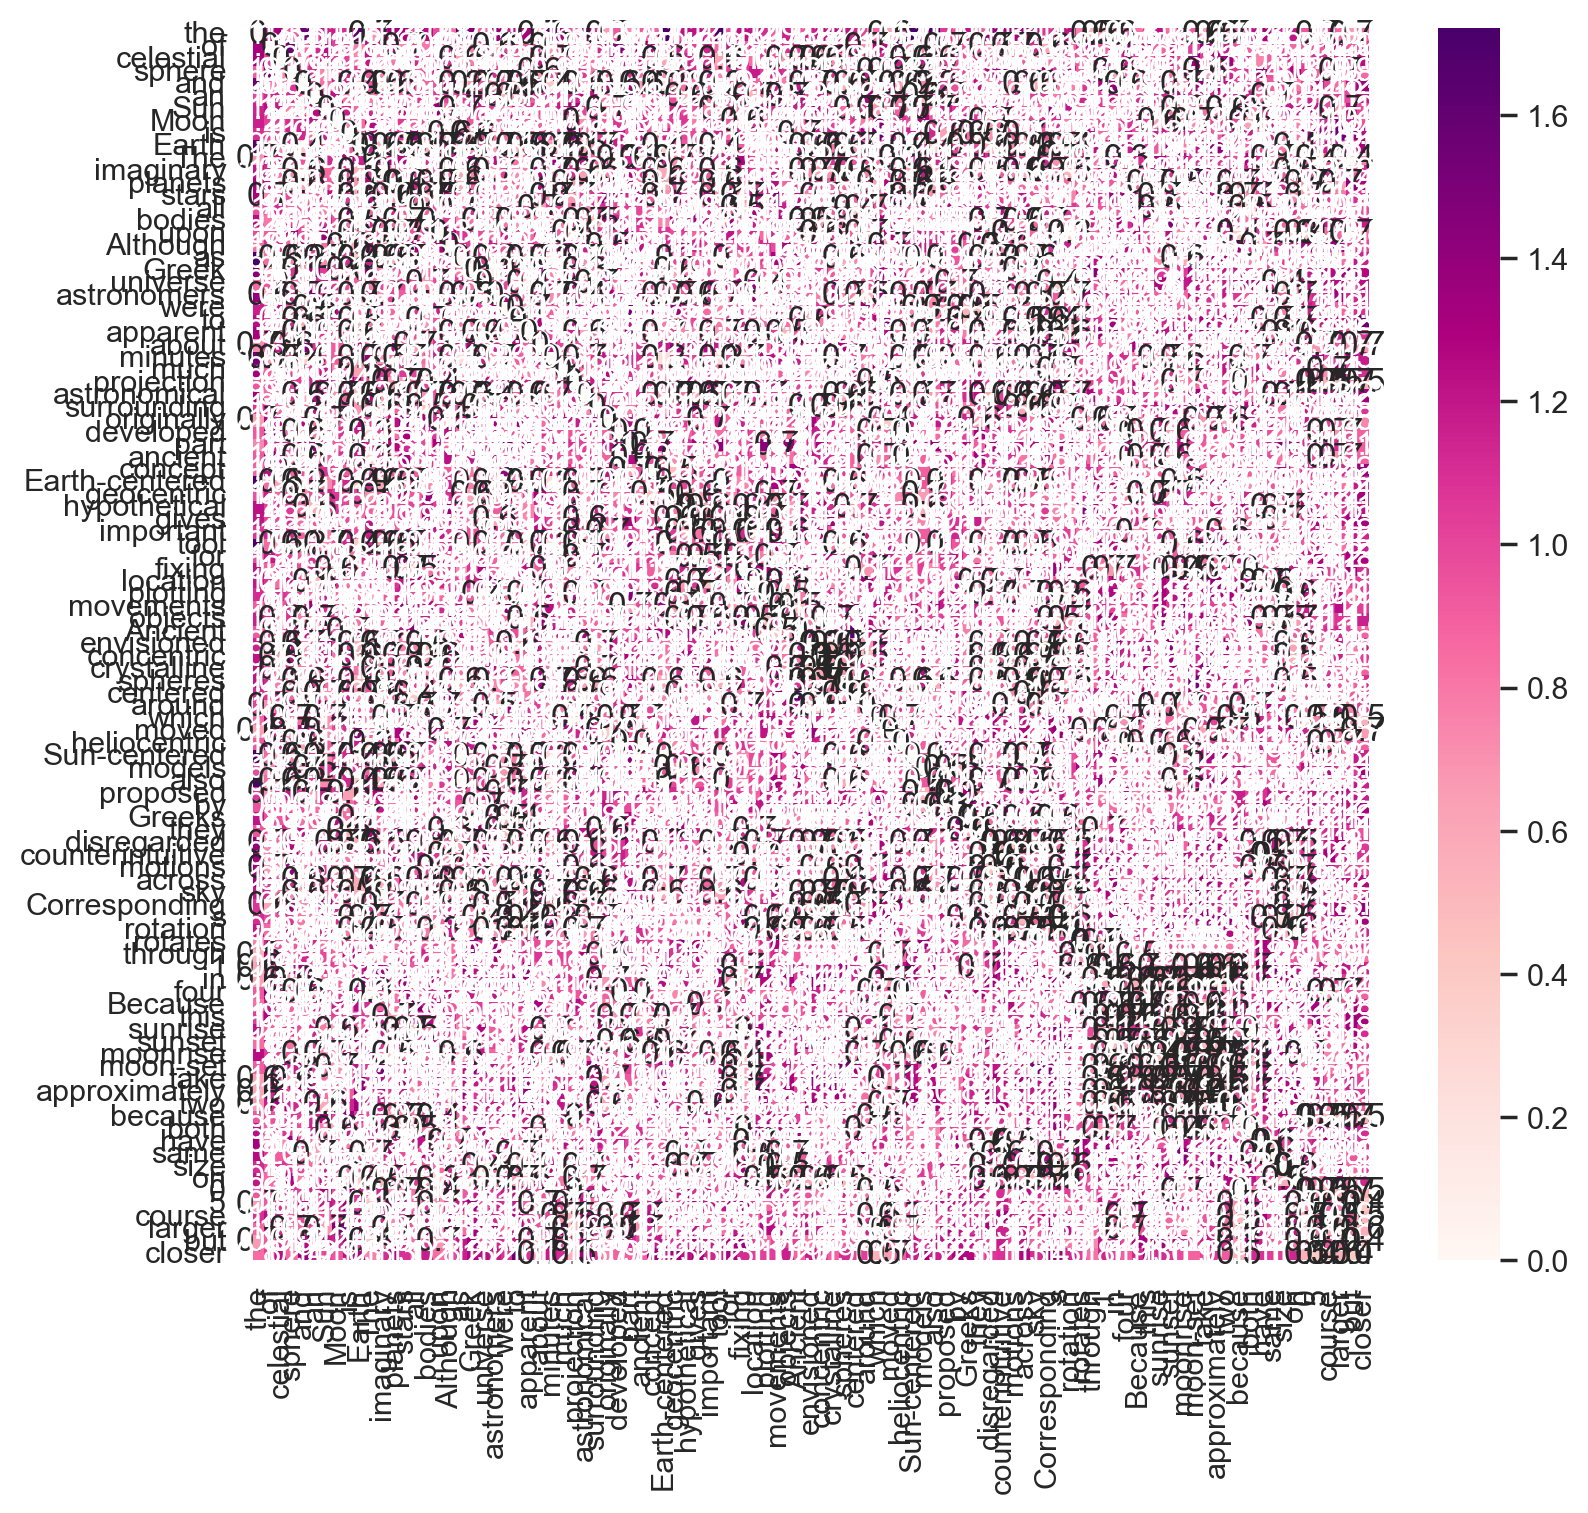

In [52]:
# very (!) slow and not very telling as it is.
# optional TODO : who can reduce the heatmap to a few frequent words?

cos_dists = scipy.spatial.distance.cdist(
    parameters["best_embeddings"], parameters["best_embeddings"], "cosine"
)
costs_heatmap(cos_dists, id2tok)

### Conclusions:

- It works, but we would like to train on a much larger corpus

  - For that, we should:
  
    - Not exceed the lines when computing the neighborhood
  
    - Use negative sampling
  
    - Maybe implement a part in C and optimized for graphic card -- 
      or use a deep learning module (PyTorch, TensorFlow...)

- We will rely on an already implemented module: **Gensim**

→ Next section

____________

### 🌸 Gensim Word Embedding

- Word embedding
 
  - 🚧 TODO: complete a function to read a pre-computed embedding
 
  - 🚧 TODO: normalize vectors
 
  - 🚧 TODO: complete the function that finds the closest words by cosine distance
 
  - 🚧 TODO: test the nearest words
 
  - 🚧 mini-TODO: complete and test the function that computes analogies to see if our plotting is biased

- Later: text classification

  - 🚧 TODO: find and remove an outlier in our texts (to understand that the method works very well if the texts are very different)

  - Optional TODO: other methods than k-nearest neighbors

  - Optional TODO: redo based on keywords only

All TODOs are marked with the symbol 🚧 

#### Load the pre-calculated word2vec 
  
  - Get `enwiki-50k_100d-clean.txt` here and put it next to your notebook 
    (recommended: `../data/enwiki/`)
  
  - It consists in a reduction to the 50k most frequent types of the full word2vec [pretrainded](https://wikipedia2vec.github.io/wikipedia2vec/pretrained/) on the complete English Wikipedia.  
  
    In particular this [file](http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.txt.bz2)
  
  - Open the file and explore the format
  
  - 🚧 Write a `read_vectors` function that gives a numpy matrix `embeddings` with one row per type (~ one word), each row represents the word. `embeddings[i, :]` corresponds to one type.

In [53]:
# # extraction from big embedding
# c = 0
# with (
#     open("enwiki-50k_100d.txt") as in_f,
#     open("enwiki-50k_100d-clean.txt", "W") as out_f,
# ):
#     for row in in_f:
#         if c == 0:
#             c += 1
#             # continue
#         if not row.strip().startswith("ENTITY/"):
#             out_f.write(row)
#             c += 1
#         if c > 50000:
#             break

In [54]:
def read_vectors(infile, vocab_size=50000, dimension=100):
    """
    function that reads a backup of an embedding
    returns
    - a word dictionary type -> index
    - the inverse dictionary
    - a matrix containing a vector of words per word type
    check the file to understand the format
    """
    embeddings = np.zeros((vocab_size, dimension))
    w2i, i2w = {}, {}  # as before
    i = 0
    for line in open(infile):
        # 🚧 TODO:
        
        splitted = line.strip().split()
        w2i[splitted[0]] = i
        i2w[i] = splitted[0]
        embeddings[i] = np.array([float(s) for s in splitted[1:]])
        i += 1

        # end TODO
    assert len(w2i) == len(i2w) == len(embeddings)
    return w2i, i2w, embeddings

In [55]:
w2i, i2w, embeddings = read_vectors(enwiki_fp)

print(len(w2i), len(i2w), embeddings.shape)

50000 50000 (50000, 100)


### Objectives

We want to make a python function that for a given word returns the K nearest (semantic) neighbors

To do this, we need to 

1. calculate the cosine distance between them

2. order the distances by decreasing orders


#### 1. Calculating the cosine distance
**Hint**, we can do this in two substeps: 
- 🚧 normalize the embeddings (with respect to the rows, i.e., each word vector to a unit norm)
- 🚧 calculate scalar product between the source word embedding with the whole embedding space

In [56]:
# 🚧 TODO: normalize the embeddings (with respect to the lines,
#     i.e. each word vector to a unit norm)

# normed_embeddings = # 🚧 TODO: ...??
normed_embeddings = preprocessing.scale(embeddings)
normed_embeddings

array([[-1.44669524e-01,  8.73889030e-01, -1.77761944e-01, ...,
        -5.16599219e-01,  8.04957312e-01,  1.24785303e-01],
       [ 4.31250387e-01,  5.91834618e-01,  5.37882477e-01, ...,
        -3.79459006e-01,  6.49112161e-01, -7.44558875e-01],
       [ 8.75472104e-02,  5.17217049e-01, -9.58306905e-02, ...,
        -5.94113253e-01,  1.02413176e+00,  4.92920020e-01],
       ...,
       [-8.06025025e-01, -1.24226524e+00,  1.07043563e+00, ...,
        -1.19437014e-01,  8.68561958e-01,  9.44734925e-01],
       [ 4.50018205e-01, -3.30412567e-04, -1.95962738e+00, ...,
        -3.16203407e-01, -8.11022183e-02,  2.94760685e-01],
       [-1.56714542e-01, -7.02332505e-01, -9.71157454e-01, ...,
         5.38265672e-01, -7.98100048e-01,  7.73597318e-01]])

**⚠ Achtung!!!**:

- To simplify the calculations later, we will base our calculations on the `normed_embeddings` matrix. Thus, we won't need to divide the dot product of the two vectors by their norms (the cosine similarity of two unit vectors is just the dot product of the vectors).

- If you want to perform a similarity calculation based on another measure (Euclidean distance?), then you will have to base your calculations on the raw `embeddings` matrix (which is not normalized!)

In [57]:
def find_closest_words_from_vector(vector, k_max=10):
    """For a given vector, find the K nearest semantic neighbors"""
    closest_words = []

    #m = vector.shape[0]
    #vector =  vector.reshape(m,1)
    cosine_similarities = np.dot(normed_embeddings,vector)
    # cosine_similarities = # 🚧 TODO: ...?? think of the scalar product
    
    sorted_indexes = np.argsort(cosine_similarities)  # matrix sorted from smallest to largest
    # sorted_indexes =    # 🚧 TODO: ...?? matrix sorted from smallest to largest

    # Only K largest is of interest to us
    for k in range(1, k_max + 1):  # to take the last elements, we start with -1
        # 🚧 TODO: ...??
        neighboor_index = sorted_indexes[k-1]
        closest_words.append((i2w[neighboor_index], cosine_similarities[neighboor_index]))
        # end TODO
    return closest_words

In [58]:
def find_closest_words_from_word(word, k_max=10):
    """For a given word 'word', find the K nearest semantic neighbors"""
    word_index = w2i[word]
    word_vector = normed_embeddings[word_index]
    closest_words = find_closest_words_from_vector(word_vector, k_max)
    return closest_words

In [59]:
def pretty_show(closest_words):
    """prettify the print for the closest words"""
    for word, similarity in closest_words:
        print(word.ljust(15, " "), similarity.round(3))
    print("___\n")

In [60]:
# Creative time! Let's test our function on some terms
pretty_show(find_closest_words_from_word("french"))
pretty_show(find_closest_words_from_word("what"))
# trained on Wikipédia. --> few swear words... (e.g., holy ...)
pretty_show(find_closest_words_from_word("holy"))
pretty_show(find_closest_words_from_word("cool"))

palomar         -55.227
baluchestan     -51.811
gracillariidae  -51.176
median          -49.024
lcdb            -48.545
turrids         -47.325
plical          -46.777
mcca            -46.768
fuscous         -46.162
qaleh           -45.47
___

socorro         -50.903
apelor          -50.164
neowise         -48.942
cadastrul       -47.49
householder     -46.898
pyrams          -46.388
lcdb            -44.84
administrația   -43.743
turrids         -43.229
kitt            -41.274
___

householder     -85.969
turrids         -59.127
bucurești       -50.842
rîurile         -50.428
eighteens       -48.142
shapefiles      -47.512
hidrologie      -47.069
postmedial      -44.318
snp             -43.56
suppressor      -42.256
___

rîurile         -63.704
hidrologie      -54.817
warmian         -53.127
250000          -49.873
prelatures      -47.633
baronetcies     -46.605
fachhochschule  -43.634
apelor          -43.416
administrația   -41.942
cadastrul       -41.791
___



### Analogies

Finally the pretty analogies in the embeddings!

In [61]:
def find_analogies(wpos1, wpos2, wneg):
    """
    wpos1: the first positive word
    wpos2: the 2nd positive word
    wneg: the negative word
    Find the analog "analog" such that 
        <"analog" is to "wpos2" what "wneg" is to "wpos1">
    For example: <"queen" is to "woman" what "king" is to "man">
    """
    # add the positive vectors, substract the negative vector:
    wpos1_index = w2i[wpos1]
    wpos2_index = w2i[wpos2]
    wneg_index = w2i[wneg]
    
    wpos1_vector = normed_embeddings[wpos1_index]
    wpos2_vector = normed_embeddings[wpos2_index]
    wneg_vector = normed_embeddings[wneg_index]
    
    vector_analog = wpos2_vector + wpos1_vector - wneg_vector # 🚧 TODO
    return find_closest_words_from_vector(vector_analog)

In [62]:
pretty_show(find_analogies("king", "woman", "man"))
pretty_show(find_analogies("nurse", "man", "woman"))  # Watch out for bias!
# 🚧 TODO: Find other "questionable" examples

wikitable       -67.387
bromeliaceae    -56.722
shapefiles      -54.607
frazioni        -51.877
regatas         -50.929
gastropod       -47.91
ribosomal       -44.939
mollusk         -44.252
colspan         -43.833
dorid           -43.127
___

apelor          -50.273
administrația   -50.137
națională       -47.044
cerambycidae    -46.651
cadastrul       -44.742
puillandre      -43.257
podlaskie       -41.9
mordellidae     -41.727
median          -39.685
româniei        -39.414
___



# 💥 Text classification by embeddings

In [63]:
retoken = re.compile(r"\w+")


def doc2vec(text):
    """
    The function takes a text, cuts it into tokens
    For each token, if the token is in w2i, we take its vector
    We add the vectors and renormalize
    Returns: vector of the same format as the ones we have for each word
    """
    tokens = retoken.findall(text)
    vectors = [normed_embeddings[w2i[t]] for t in tokens if t in w2i]
    somme = sum(vectors)
    normalised = somme / np.sqrt(np.sum(somme ** 2))
    return normalised


vex = doc2vec("let's see how this works, this word2vec thing!")
vex

array([ 1.41909353e-01,  1.37284680e-02, -1.35461817e-01,  2.17850197e-01,
       -1.10801796e-02,  1.00490005e-01, -9.53114750e-03, -6.54132065e-02,
       -8.75316747e-02,  2.71076752e-04,  3.65660164e-02,  4.87341083e-02,
       -6.01058529e-02,  3.27295587e-01,  2.02647314e-01, -6.64880108e-02,
       -1.91634705e-01, -7.31860762e-02, -2.53787663e-02,  8.21220177e-03,
       -1.15808642e-01, -1.89790955e-01,  4.27762856e-02,  1.20950317e-01,
       -1.58428616e-02,  7.28845928e-04,  6.70622885e-03,  4.81287073e-02,
       -8.82529575e-02,  8.17068974e-02, -8.77379918e-02,  1.74661619e-01,
       -9.72714157e-03, -8.14847811e-02, -1.91831399e-01,  1.76518660e-01,
        1.61399043e-01,  4.20035415e-02, -1.20463359e-01, -2.83262730e-02,
        4.02606099e-02,  1.17514905e-01,  1.12634544e-01, -5.85083236e-02,
       -9.57656055e-02, -1.26803119e-03, -2.82313148e-02,  1.00043792e-01,
       -3.35137915e-02,  1.55298992e-01, -1.19087909e-01,  4.39802129e-02,
        1.45973373e-03, -

---